In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.abspath("."))

In [2]:
import utils_io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import yaml
import json
import torch
from tqdm.notebook import tqdm
# --- Import our custom modules ---
# Use autoreload to pick up changes in .py files without restarting kernel
%load_ext autoreload
%autoreload 2


# --- Matplotlib Aesthetics Settings ---
plt.rcParams.update({
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "font.family": "serif",
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1,
    'grid.alpha': 0.5,
    'grid.color': '#c0c0c0',
    'grid.linestyle': '--',
    'grid.linewidth': 0.8,
    'figure.dpi': 300,
    'figure.edgecolor': 'black',
    'figure.facecolor': 'white',
    'figure.figsize': [6, 5],
})

# Load all seeds for 'diag' structure
data_diag = utils_io.load_results_from_dir('results/study_q2approx_v1/sequential')

# (You'll need logic to separate 'diag' from 'block' folders if they are in same parent,
# or save them in different parents like results/exp_diag/seed_x)

Directory not found: results/study_q2approx_v1/sequential


In [69]:
L_metrics = ["sharpness_curr", "trace_curr", "sharpness_past", "trace_past", "grad_cos_sim", "grad_norm_reg", "grad_norm_task"]
P_metrics = ["accuracy", "task_loss", "reg_loss", "all_accuracy", "reg_accuracy"]

In [4]:
ROOT_DIR = './results/study_q2approx_v1'

## Approximation errors for different approximations 

In [5]:
def get_experiment_index(root_dir):
    """
    Scans config files and indexes experiments by their parameters.
    Extracts: mode, reg_type, seed, AND curvature.
    """
    configs = []
    files = glob.glob(os.path.join(root_dir, '**', 'config.yaml'), recursive=True)
    
    print(f"Indexing {len(files)} experiments...")
    for f in files:
        try:
            with open(f, 'r') as stream:
                try:
                    cfg = json.load(stream)
                except:
                    stream.seek(0)
                    cfg = yaml.safe_load(stream)
            
            # Robust extraction using keys from config
            configs.append({
                'config': cfg,
                'metrics_path': os.path.join(os.path.dirname(f), 'metrics.pt'),
                
                # Metadata for filtering
                'mode': cfg.get('training_mode', cfg.get('mode', 'unknown')),
                'reg_type': cfg.get('reg_type'),
                'seed': cfg.get('seed'),
                'alpha': cfg.get('alpha'),
                'curvature': cfg.get('curvature_type', 'hessian'), 
                'ignore_gradient': cfg.get('ignore_gradient', False) 
            })
        except Exception as e:
            continue
    return configs

def plot_trajectory_on_ax(ax, results, config, sample_ids='mean', metric_root='kappa_loss', use_abs=True):
    """
    Draws trajectory lines on a given axis.
    
    Args:
        metric_root: 'kappa_loss', 'kappa_grad', 'cos_sim'
        sample_ids: List of ints OR 'mean' to plot average with std band.
    """
    num_tasks = config['environment_args']['num_tasks']
    num_steps = config['num_steps']
    
    # Define metric keys based on root
    key_acc = f"{metric_root}_acc"
    key_res = f"{metric_root}_res"
    
    steps_axis = []
    
    # Containers for data aggregation
    # structure: [step_index] -> list of values (one per sample)
    data_acc = [] 
    data_res = []
    
    curr_step = 0
    
    # --- 1. Extract Data ---
    for t in range(1, num_tasks):
        if t not in results or 'history' not in results[t]:
            # Add placeholders or skip
            curr_step += num_steps
            continue
            
        history = results[t]['history']
        task_x = np.linspace(0, num_steps, len(history))
        
        for i, step_data in enumerate(history):
            steps_axis.append(curr_step + task_x[i])
            
            vals_a = []
            vals_r = []
            
            # Helper to safely extract and optionally apply abs
            def get_val(sample_dict, k):
                val = sample_dict.get(k, np.nan)
                if use_abs and not np.isnan(val):
                    return abs(val)
                return val

            # Extraction Logic
            if isinstance(sample_ids, list):
                for s_id in sample_ids:
                    if len(step_data) > s_id:
                        vals_a.append(get_val(step_data[s_id], key_acc))
                        vals_r.append(get_val(step_data[s_id], key_res))
            
            elif sample_ids == 'mean':
                for sample_stat in step_data:
                    vals_a.append(get_val(sample_stat, key_acc))
                    vals_r.append(get_val(sample_stat, key_res))
            
            data_acc.append(vals_a)
            data_res.append(vals_r)

        curr_step += num_steps

    if not steps_axis: return

    if isinstance(sample_ids, list):
        # --- Plot Individual Samples ---
        cmap_acc = plt.cm.Reds
        cmap_res = plt.cm.Blues
        colors_acc = cmap_acc(np.linspace(0.5, 1, len(sample_ids)))
        colors_res = cmap_res(np.linspace(0.5, 1, len(sample_ids)))
        
        # We need to transpose data: [steps][samples] -> [samples][steps]
        # Using numpy for easy slicing, padding with nan if lengths differ
        # (Simplified loop since we built flat lists above, but we need structure)
        
        # Re-looping for plotting simply:
        # Since aggregating data_acc is jagged (diff samples per step possible), 
        # we'll plot point-by-point or rebuild the structure. 
        # Actually, simpler to just iterate extraction logic again or restructure data_acc.
        # Let's use the simplest approach: Re-extract per sample ID.
        
        # (Redoing loop for clarity/robustness with Matplotlib lines)
        # Re-extract just for clean plotting loop (simplified)
        curr_step = 0
        for idx, s_id in enumerate(sample_ids):
            s_steps = []
            s_vals_a = []
            s_vals_r = []
            curr_step = 0
            for t in range(1, num_tasks):
                history = results.get(t, {}).get('history', [])
                task_x = np.linspace(0, num_steps, len(history))
                for i, step_data in enumerate(history):
                    if len(step_data) > s_id:
                        s_steps.append(curr_step + task_x[i])
                        # Apply abs if requested
                        va = step_data[s_id].get(key_acc, np.nan)
                        vr = step_data[s_id].get(key_res, np.nan)
                        if use_abs:
                            va = abs(va) if not np.isnan(va) else va
                            vr = abs(vr) if not np.isnan(vr) else vr
                        s_vals_a.append(va)
                        s_vals_r.append(vr)
                curr_step += num_steps
            
            ax.plot(s_steps, s_vals_a, color=colors_acc[idx], ls='-', lw=1.5, alpha=0.8)
            ax.plot(s_steps, s_vals_r, color=colors_res[idx], ls='--', lw=1.5, alpha=0.8)

    elif sample_ids == 'mean':
        # --- Plot Average with Shaded Std Dev ---
        # Note: Values are already abs() inside data_acc/data_res if use_abs=True
        
        means_acc = np.array([np.nanmean(v) for v in data_acc])
        stds_acc  = np.array([np.nanstd(v) for v in data_acc])
        
        means_res = np.array([np.nanmean(v) for v in data_res])
        stds_res  = np.array([np.nanstd(v) for v in data_res])
        
        ax.plot(steps_axis, means_acc, color='darkred', ls='-', lw=2, label='Accum Mean')
        ax.plot(steps_axis, means_res, color='darkblue', ls='--', lw=2, label='Reset Mean')
        
        ax.fill_between(steps_axis, means_acc - stds_acc, means_acc + stds_acc, color='red', alpha=0.15)
        ax.fill_between(steps_axis, means_res - stds_res, means_res + stds_res, color='blue', alpha=0.15)
        
        # Heuristic Y-Limit for Error Plots
        if use_abs: 
            pass
            # ax.set_ylim(0, max(np.nanmax(means_res), np.nanmax(means_acc)) * 1.5)

    # Boundaries & Grid
    for t in range(1, num_tasks):
        ax.axvline(x=t * num_steps, color='gray', linestyle=':', alpha=0.3)

    # Dynamic Limits based on metric type
    if 'cos_sim' in metric_root:
        ax.set_ylim(-1.1, 1.1) # Cosine sim is bounded
    else:
        # Heuristic limits for Kappa errors which can explode
        # ax.set_ylim(min(-1, plot_y_min), min(plot_y_max * 1.2, 50.0))
        pass

    ax.grid(True, linestyle=':', alpha=0.5)

def plot_grid(root_dir, metric='kappa_loss', sample_ids='mean', seed_to_plot=42, 
              curvature='hessian', ignore_gradient=False, use_abs=None):
    """
    Plots a grid of results (Modes x RegTypes).
    
    Args:
        curvature (str): 'hessian' or 'fisher'
        ignore_gradient (bool): True to see experiments where g*delta was dropped.
    """
    
    # Auto-detect absolute value
    if use_abs is None:
        use_abs = True if 'kappa' in metric else False

    index = get_experiment_index(root_dir)
    
    modes = ['sequential', 'regularized', 'replay']
    reg_types = ['taylor-diag', 'taylor-block', 'taylor-full']
    
    rows, cols = len(modes), len(reg_types)
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows), dpi=150, sharex=True, sharey=False)
    
    if rows == 1 and cols == 1: axes = np.array([[axes]])
    elif rows == 1: axes = axes[np.newaxis, :]
    elif cols == 1: axes = axes[:, np.newaxis]

    grad_status = "NoGrad" if ignore_gradient else "WithGrad"
    print(f"Plotting {metric} | {curvature} | {grad_status} | Seed {seed_to_plot}")

    for r, mode in enumerate(modes):
        for c, reg in enumerate(reg_types):
            ax = axes[r, c]
            
            # --- FILTERING LOGIC ---
            match = None
            for item in index:
                if (item['mode'] == mode and 
                    item['reg_type'] == reg and 
                    item['seed'] == seed_to_plot and 
                    item['curvature'] == curvature and 
                    item.get('ignore_gradient', False) == ignore_gradient): # <--- NEW FILTER
                    
                    match = item
                    break
            
            if match:
                try:
                    results = torch.load(match['metrics_path'], map_location='cpu', weights_only=False)
                    config = match['config']
                    plot_trajectory_on_ax(ax, results, config, sample_ids=sample_ids, metric_root=metric, use_abs=use_abs)
                    
                    if r == 0: ax.set_title(f"{reg}", fontsize=14, fontweight='bold')
                    if c == 0: ax.set_ylabel(f"{mode}\n{metric}", fontsize=12, fontweight='bold')
                except Exception as e:
                    ax.text(0.5, 0.5, f"Error: {e}", ha='center', transform=ax.transAxes, fontsize=8)
            else:
                ax.text(0.5, 0.5, "No Data", ha='center', transform=ax.transAxes, color='gray')
                if r == 0: ax.set_title(f"{reg}")
                if c == 0: ax.set_ylabel(f"{mode}")

    # Legend
    from matplotlib.lines import Line2D
    custom_lines = [
        Line2D([0], [0], color='darkred', lw=2, linestyle='-'),
        Line2D([0], [0], color='darkblue', lw=2, linestyle='--')
    ]
    fig.legend(custom_lines, ['Accumulate (Robust)', 'Reset (Unstable)'], 
               loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=2, fontsize=12)
    
    plt.tight_layout()
    plt.show()

Indexing 98 experiments...
Plotting kappa_loss | fisher | NoGrad | Seed 33


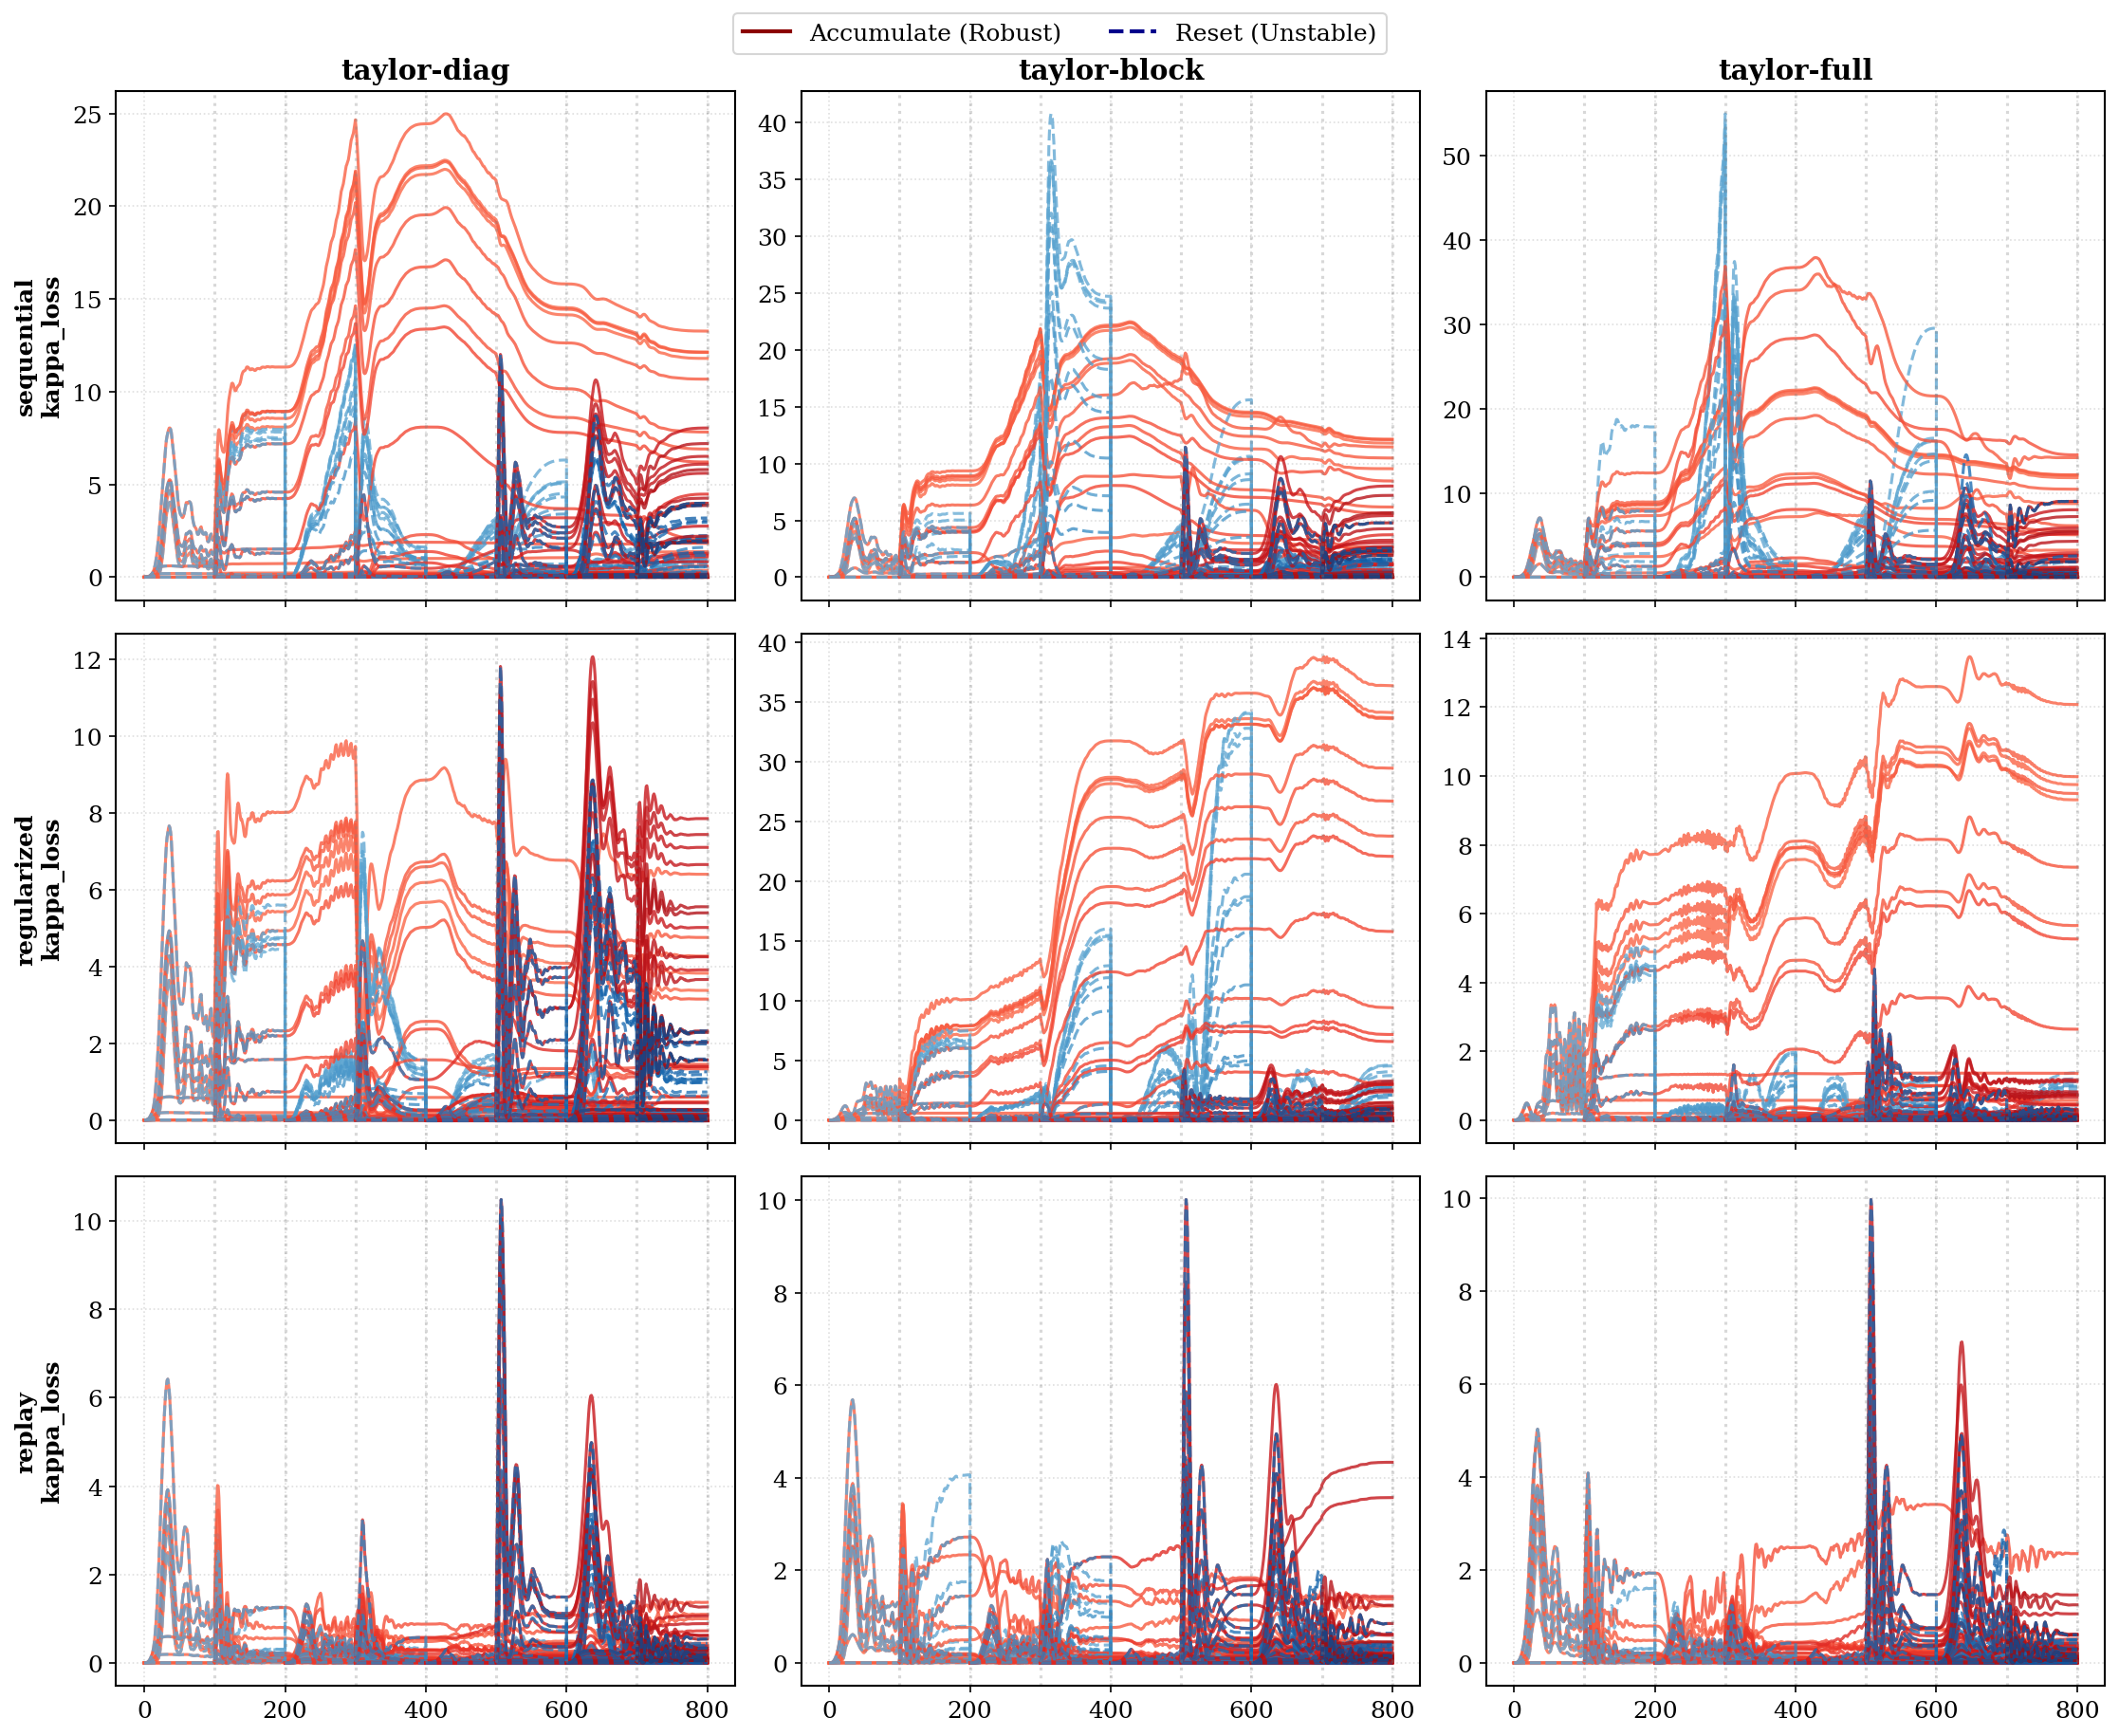

In [77]:
# 1. Average Kappa Error (All Samples)
samples = list(range(100))
# plot_grid(ROOT_DIR, metric='kappa_loss', sample_ids=samples, seed_to_plot=33, 
            #   curvature='hessian', use_abs=True, ignore_gradient=False)
plot_grid(ROOT_DIR, metric='kappa_loss', sample_ids=samples, seed_to_plot=33, 
              curvature='fisher', use_abs=True, ignore_gradient=True)

# # 2. Individual Samples - Gradient Norm Error
# plot_grid(ROOT_DIR, metric='kappa_grad', sample_ids=[0, 10, 20])

# # 3. Average Cosine Similarity
# plot_grid(ROOT_DIR, metric='cos_sim', sample_ids='mean')

In [7]:
def extract_trajectory_series(results, config, metric_root, sample_ids='mean', use_abs=False):
    """
    Extracts time series data. Handles both split metrics (kappa_loss_acc/res) 
    and shared metrics (accuracy).
    """
    num_tasks = config['environment_args']['num_tasks']
    num_steps = config['num_steps']
    if metric_root in L_metrics: keyword = 'landscape'
    if metric_root in P_metrics: keyword = 'performance'
    else: keyword = 'history'
    
    # 1. Determine Keys
    # If metric is 'accuracy', it exists as a single key, so we use it for both lines
    if metric_root == 'accuracy':
        key_acc = 'accuracy'
        key_res = 'accuracy'
    elif metric_root in L_metrics or metric_root in P_metrics: 
        key_acc = metric_root
        key_res = metric_root
    else:
        key_acc = f"{metric_root}_acc"
        key_res = f"{metric_root}_res"
    
    steps_axis = []
    vals_acc = []
    vals_res = []
    
    curr_step = 0
    
    # Helper to get value safely
    def get_val(d, k):
        v = d.get(k, np.nan)
        if use_abs and not np.isnan(v): return abs(v)
        return v

    for t in range(1, num_tasks):
        if t not in results or keyword not in results[t]:
            curr_step += num_steps
            continue
            
        history = results[t][keyword]
        task_x = np.linspace(0, num_steps, len(history))
        
        for i, step_data in enumerate(history):
            steps_axis.append(curr_step + task_x[i])
            
            step_v_a = []
            step_v_r = []

            
            # Collection Logic
            if sample_ids == 'mean':
                if keyword=="history": 
                    for s_stat in step_data:
                        step_v_a.append(get_val(s_stat, key_acc))
                        step_v_r.append(get_val(s_stat, key_res))
                else: 
                    # the value is already the average 
                    step_v_a = [get_val(step_data, key_acc)]
                    step_v_r = [get_val(step_data, key_res)]
            elif isinstance(sample_ids, list):
                for s_id in sample_ids:
                    if len(step_data) > s_id:
                        step_v_a.append(get_val(step_data[s_id], key_acc))
                        step_v_r.append(get_val(step_data[s_id], key_res))
            
            
            # Aggregation (Mean across samples for this time step)
            vals_acc.append(np.nanmean(step_v_a))
            vals_res.append(np.nanmean(step_v_r))

        curr_step += num_steps
        
    return np.array(steps_axis), np.array(vals_acc), np.array(vals_res)

In [8]:
def plot_metric_comparison(root_dir, metric='kappa_loss', 
                           compare_by='reg_type', 
                           fixed_params={'mode': 'regularized'},
                           curvature='hessian',
                           ignore_gradient=False, # Default filter
                           strategy='accumulate', 
                           sample_ids='mean'):
    """
    Plots a comparison of aggregated trajectories.
    
    Args:
        compare_by: Variable to use for colors ('ignore_gradient', 'reg_type', etc.)
        ignore_gradient: Filter value (True/False). Ignored if compare_by='ignore_gradient'.
    """
    
    index = get_experiment_index(root_dir)
    
    # Filter Experiments
    relevant_exps = []
    for item in index:
        
        # 1. Check Curvature
        if item.get('curvature') != curvature: continue
        
        # 2. Check Ignore Gradient (ONLY if we are not comparing by it)
        # If we compare by it, we want BOTH True and False to pass through
        if compare_by != 'ignore_gradient':
            if item.get('ignore_gradient', False) != ignore_gradient: continue

        # 3. Check User Fixed Params
        match = True
        for k, v in fixed_params.items():
            if item.get(k) != v:
                match = False
                break
        if match:
            relevant_exps.append(item)
            
    # Grouping
    groups = {}
    for item in relevant_exps:
        # Handle boolean keys nicely for labels
        key = item.get(compare_by, 'unknown')
        if isinstance(key, bool) and compare_by == 'ignore_gradient':
            key = "No Gradient" if key else "With Gradient"
            
        if key not in groups: groups[key] = []
        groups[key].append(item)
        
    if not groups:
        print("No matching experiments found!")
        return

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
    unique_keys = sorted(groups.keys())
    colors = plt.cm.tab10(np.linspace(0.1, 0.9, len(unique_keys)))
    
    print(f"Comparing {compare_by} (Curv: {curvature}, IgnGrad: {ignore_gradient if compare_by != 'ignore_gradient' else 'VAR'})...")

    for idx, group_key in enumerate(unique_keys):
        seed_items = groups[group_key]
        color = colors[idx]
        
        acc_list = []
        res_list = []
        steps_ref = None
        
        for m in seed_items:
            try:
                res = torch.load(m['metrics_path'], map_location='cpu', weights_only=False)
                cfg = m['config']
                use_abs = True if 'kappa' in metric else False
                
                steps, v_acc, v_res = extract_trajectory_series(
                    res, cfg, metric, sample_ids, use_abs
                )
                
                if steps_ref is None: steps_ref = steps
                elif len(steps) != len(steps_ref):
                    mn = min(len(steps), len(steps_ref))
                    steps = steps[:mn]; v_acc = v_acc[:mn]; v_res = v_res[:mn]
                    steps_ref = steps_ref[:mn]
                    acc_list = [x[:mn] for x in acc_list]
                    res_list = [x[:mn] for x in res_list]

                acc_list.append(v_acc)
                res_list.append(v_res)
            except: continue
            
        if not acc_list: continue
        
        mean_acc = np.nanmean(np.vstack(acc_list), axis=0)
        std_acc = np.nanstd(np.vstack(acc_list), axis=0)
        mean_res = np.nanmean(np.vstack(res_list), axis=0)
        std_res = np.nanstd(np.vstack(res_list), axis=0)
        
        if strategy in ['accumulate', 'both']:
            ax.plot(steps_ref, mean_acc, color=color, ls='-', lw=2, label=f"{group_key} (Accum)")
            ax.fill_between(steps_ref, mean_acc-std_acc, mean_acc+std_acc, color=color, alpha=0.1)
            
        if strategy in ['reset', 'both']:
            ls = '--' if strategy == 'both' else '-'
            label = f"{group_key} (Reset)" if strategy == 'both' else f"{group_key}"
            ax.plot(steps_ref, mean_res, color=color, ls=ls, lw=2, label=label)
            if strategy == 'reset':
                ax.fill_between(steps_ref, mean_res-std_res, mean_res+std_res, color=color, alpha=0.1)
                
    fixed_params_str = ', '.join([f"{k}={v}" for k, v in fixed_params.items()])
    ax.set_title(f"Comparison of {metric}\n( {fixed_params_str} )", fontsize=14)
    ax.set_ylabel(metric + (" (MAE)" if 'kappa' in metric else ""))
    ax.set_xlabel("Global Steps")
    
    # Boundaries
    num_tasks = seed_items[0]['config']['environment_args']['num_tasks']
    num_steps = seed_items[0]['config']['num_steps']
    for t in range(1, num_tasks):
        ax.axvline(x=t*num_steps, color='gray', linestyle=':', alpha=0.3)
        
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


Indexing 98 experiments...
Comparing reg_type (Curv: fisher, IgnGrad: False)...


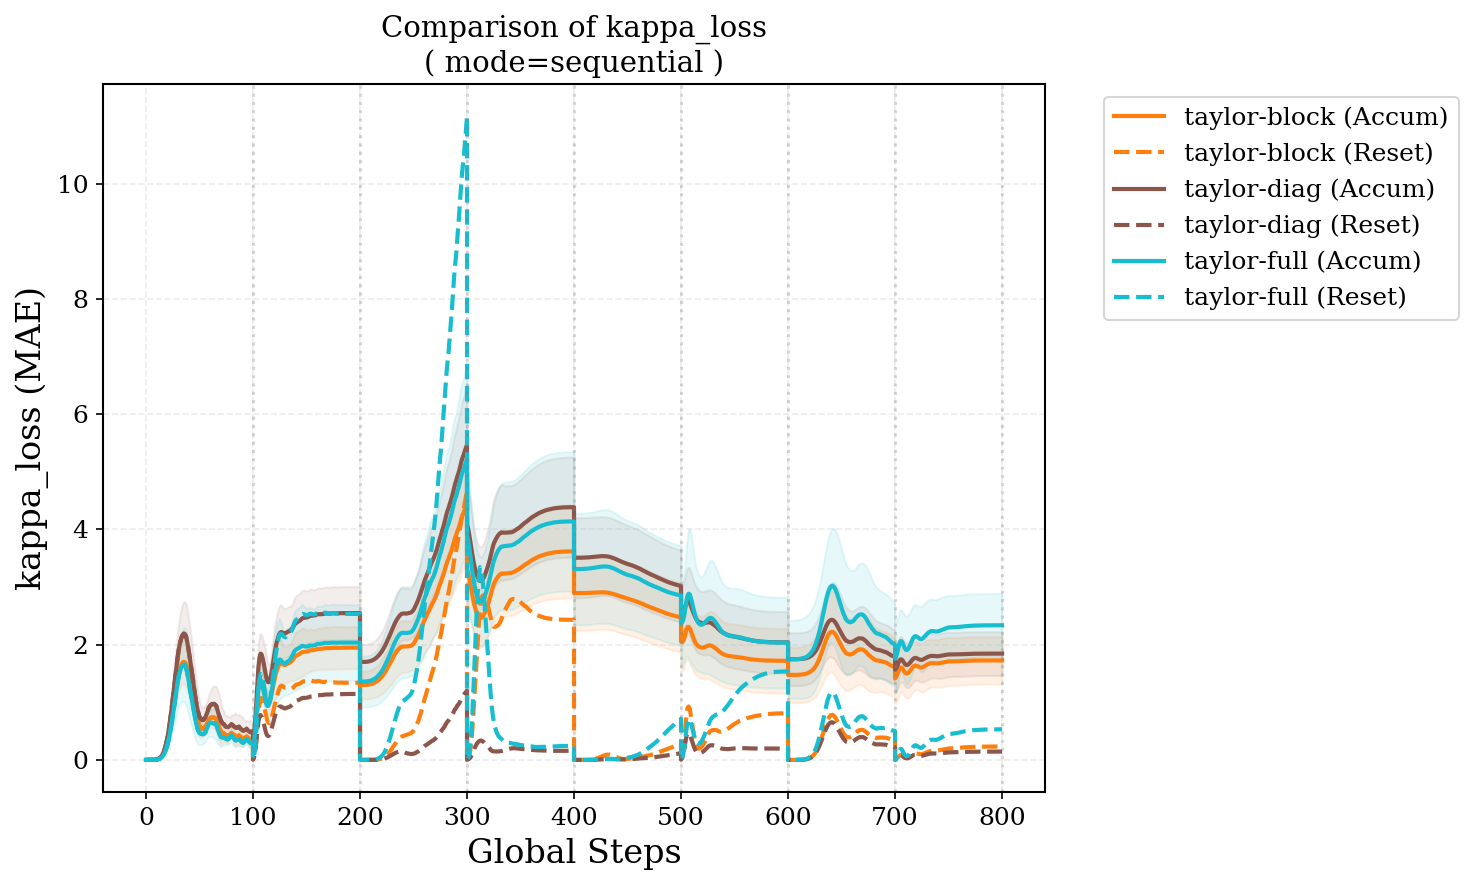

Indexing 98 experiments...
Comparing reg_type (Curv: fisher, IgnGrad: False)...


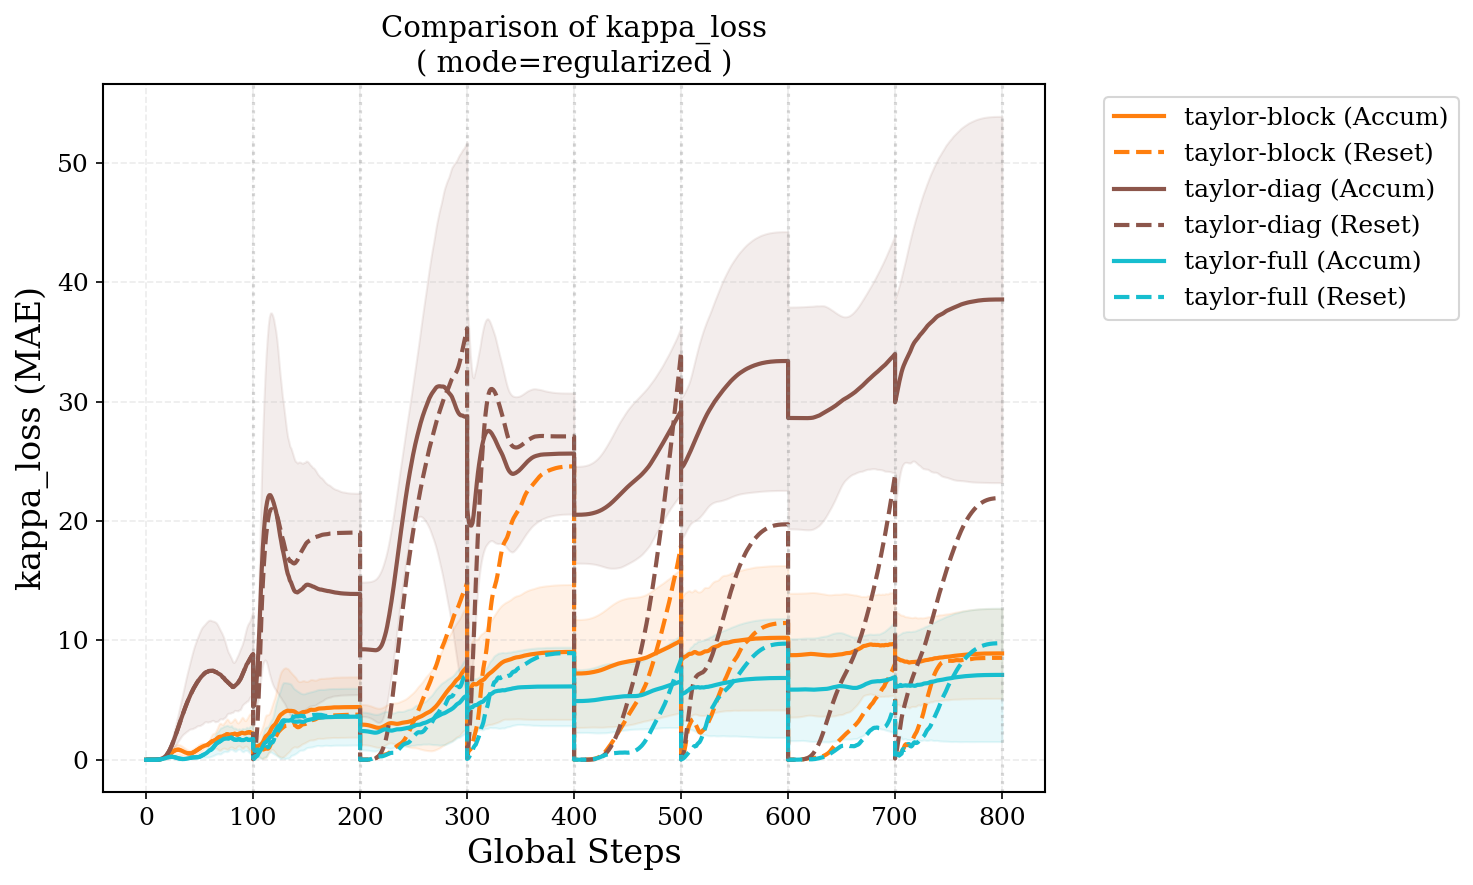

Indexing 98 experiments...
Comparing reg_type (Curv: fisher, IgnGrad: False)...


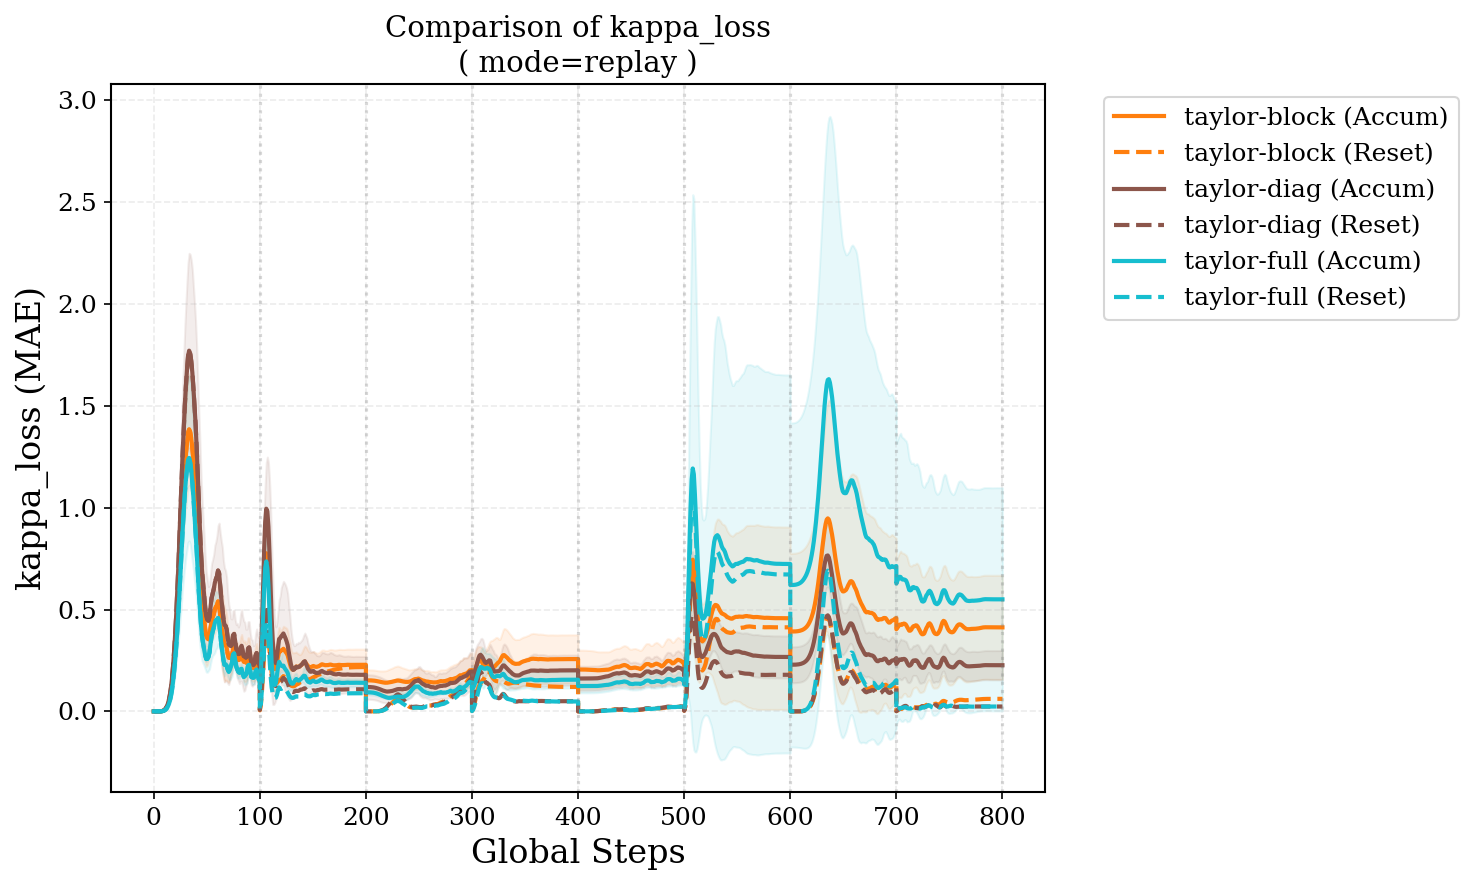

In [15]:
ROOT_DIR = './results/study_q2approx_v1'

plot_metric_comparison(
    ROOT_DIR, 
    metric='kappa_loss',
    compare_by='reg_type', # <--- Auto-disables the ignore_gradient filter
    fixed_params={'mode': 'sequential'},
    curvature='fisher',
    strategy='both' , 
    ignore_gradient=False
)

plot_metric_comparison(
    ROOT_DIR, 
    metric='kappa_loss',
    compare_by='reg_type', # <--- Auto-disables the ignore_gradient filter
    fixed_params={'mode': 'regularized'},
    curvature='fisher',
    strategy='both', 
    ignore_gradient=False
)

plot_metric_comparison(
    ROOT_DIR, 
    metric='kappa_loss',
    compare_by='reg_type',               # <--- Different colors for Diag/Full
    fixed_params={'mode': 'replay'},
    strategy='both',               # <--- Look at the "Stable" version
    curvature='fisher', 
    ignore_gradient=False
)

In [16]:
def plot_summary_boxplot(root_dir, 
                         metric='kappa_loss', 
                         compare_by='reg_type', 
                         fixed_params={'mode': 'regularized'}, 
                         curvature='hessian',
                         ignore_gradient=False,
                         sample_ids='mean',
                         use_abs=None):
    """
    Collapses the entire training trajectory into a single scalar (Average) per seed
    and plots the distribution across experiments using Box Plots.
    
    Args:
        compare_by (str): Variable for X-axis ('reg_type', 'mode', 'curvature', 'ignore_gradient', 'alpha').
        fixed_params (dict): Filters for other variables.
    """
    
    # 1. Auto-detect Absolute Value
    if use_abs is None:
        use_abs = True if 'kappa' in metric else False
        
    # 2. Get Index and Filter
    index = get_experiment_index(root_dir)
    
    relevant_exps = []
    for item in index:
        # Check Curvature
        if compare_by != 'curvature':
            if item.get('curvature') != curvature: continue
        
        # Check Ignore Gradient (Unless we are comparing by it)
        if compare_by != 'ignore_gradient':
            if item.get('ignore_gradient', False) != ignore_gradient: continue
            
        # Check Fixed Params
        match = True
        for k, v in fixed_params.items():
            if item.get(k) != v:
                match = False
                break
        if match:
            relevant_exps.append(item)
            
    if not relevant_exps:
        print("No matching experiments found.")
        return

    # 3. Data Collection Loop
    records = []
    print(f"Aggregating {len(relevant_exps)} experiments...")
    
    for item in relevant_exps:
        try:
            # Load Data
            res = torch.load(item['metrics_path'], map_location='cpu', weights_only=False)
            cfg = item['config']
            
            # Extract Time Series (Steps x 1)
            steps, v_acc, v_res = extract_trajectory_series(
                res, cfg, metric, sample_ids, use_abs
            )
            
            # COLLAPSE TIME: Compute Global Mean for this seed
            # (You could also use median, max, or final value)
            mean_acc = np.nanmean(v_acc)
            mean_res = np.nanmean(v_res)
            
            # Handle Group Label (Convert bools/floats to string for plotting)
            label = item.get(compare_by, 'Unknown')
            if isinstance(label, bool) and compare_by == 'ignore_gradient':
                label = "No Gradient" if label else "With Gradient"
            
            # Append Accumulate Record
            records.append({
                'Group': str(label),
                'Strategy': 'Accumulate',
                'Value': mean_acc,
                'Seed': item['seed']
            })
            
            # Append Reset Record
            records.append({
                'Group': str(label),
                'Strategy': 'Reset',
                'Value': mean_res,
                'Seed': item['seed']
            })
            
        except Exception as e:
            # print(f"Error loading {item['metrics_path']}: {e}")
            continue

    # 4. Create DataFrame
    df = pd.DataFrame(records)
    
    # Sort the groups logically if possible
    try:
        df = df.sort_values(by='Group')
    except: pass

    # 5. Plotting
    plt.figure(figsize=(10, 6), dpi=150)
    
    # A. The Box Plot (Distribution)
    sns.boxplot(
        data=df, 
        x='Group', 
        y='Value', 
        hue='Strategy',
        palette={'Accumulate': "#e3cf4f", 'Reset': "#b4da77"}, # Lighter pastel colors
        showfliers=False, # Hide outliers (points show them anyway)
        gap=0.1
    )
    
    # B. The Strip Plot (Individual Seeds)
    # Dodge=True aligns points with the split hue boxes
    sns.stripplot(
        data=df, 
        x='Group', 
        y='Value', 
        hue='Strategy',
        palette={'Accumulate': "#d4bb1d", 'Reset': "#b4da77"},
        dodge=True, 
        jitter=True, 
        alpha=0.6,
        legend=False
    )

    # Styling
    title_str = f"Average {metric} across Training Trajectory\n" + f"(Fixed: {fixed_params}" 
    title_str+= f", Curv: {curvature}" if compare_by != 'curvature' else "" 
    title_str+= f", Ignore Grad: {ignore_gradient})" if compare_by != 'ignore_gradient' else ")"
    plt.title(title_str)
    plt.ylabel(f"Global Average {metric}" + (" (MAE)" if use_abs else ""))
    plt.xlabel(compare_by.replace('_', ' ').title())
    plt.grid(True, axis='y', alpha=0.3)
    
    # Fix Legend (Boxplot creates one, strip plot creates one, we keep one)
    # Seaborn usually handles this, but we move it outside
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Approximation')
    
    plt.tight_layout()
    plt.show()

Indexing 98 experiments...
Aggregating 13 experiments...


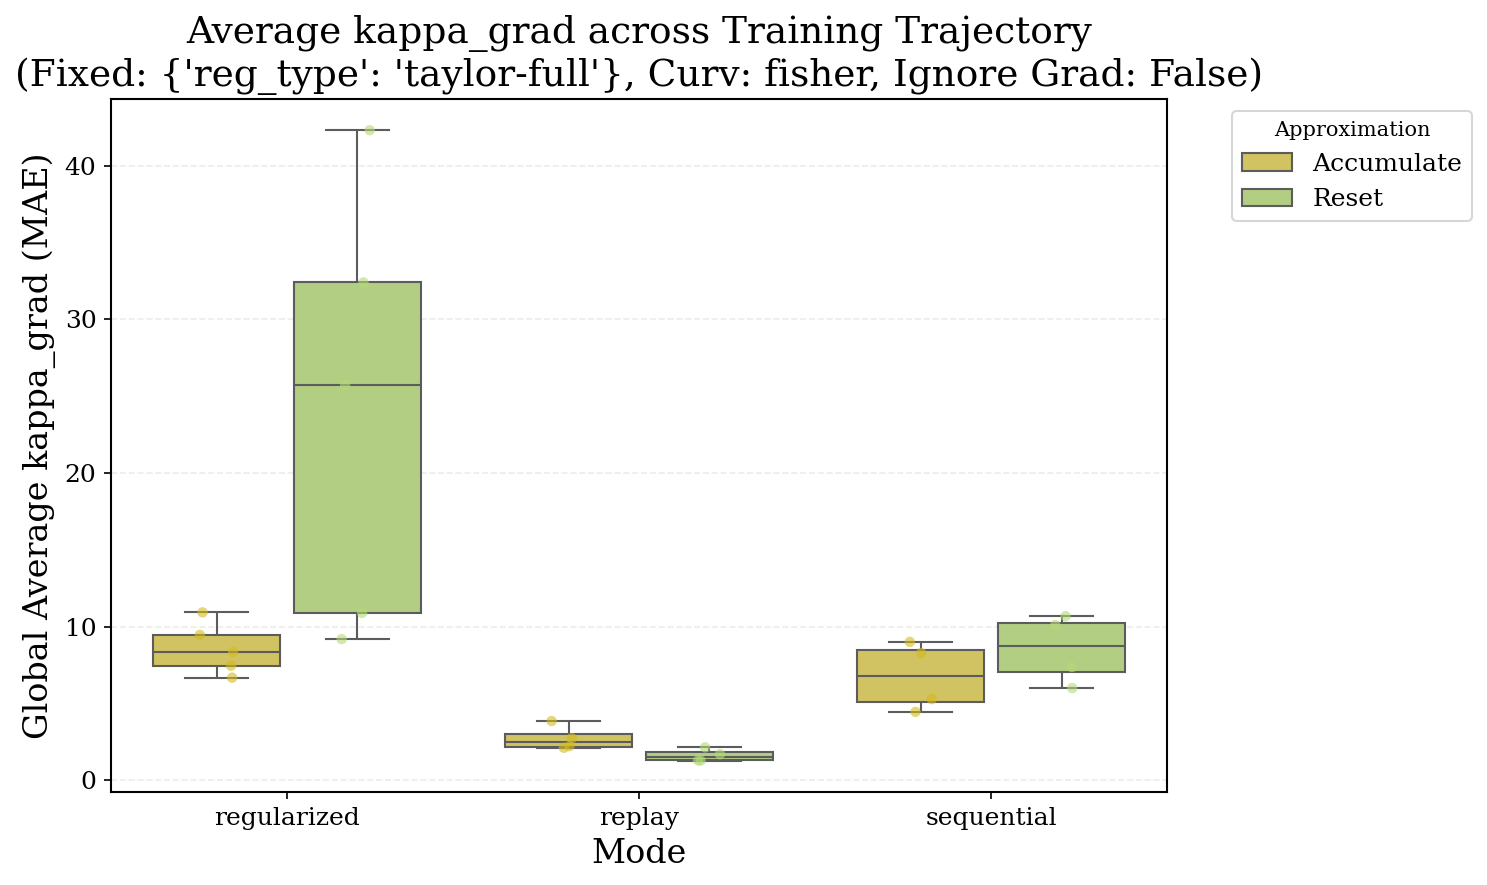

Indexing 98 experiments...
Aggregating 15 experiments...


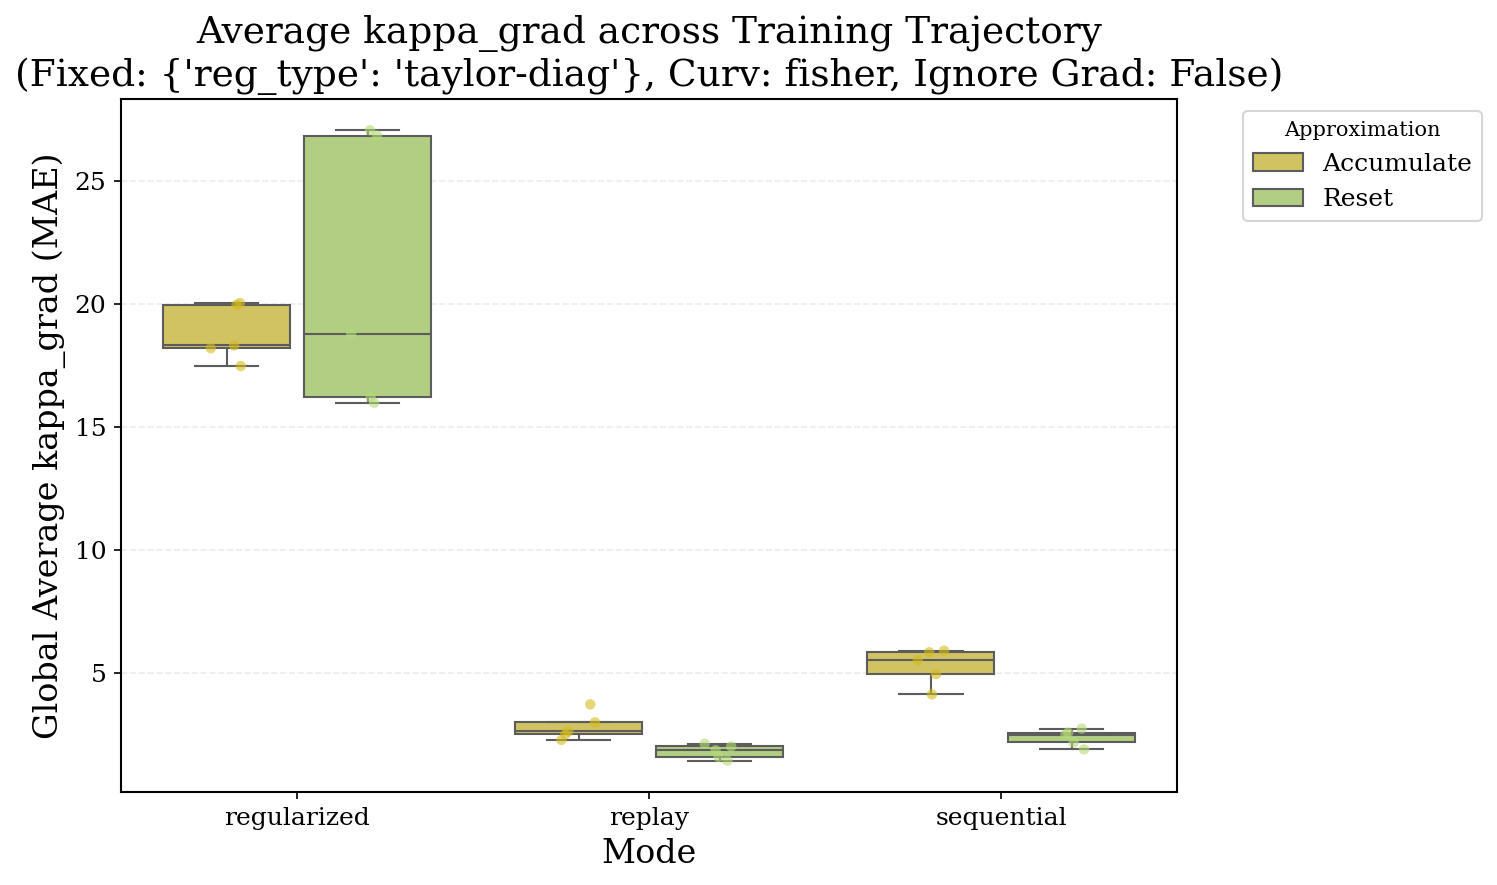

Indexing 98 experiments...
Aggregating 15 experiments...


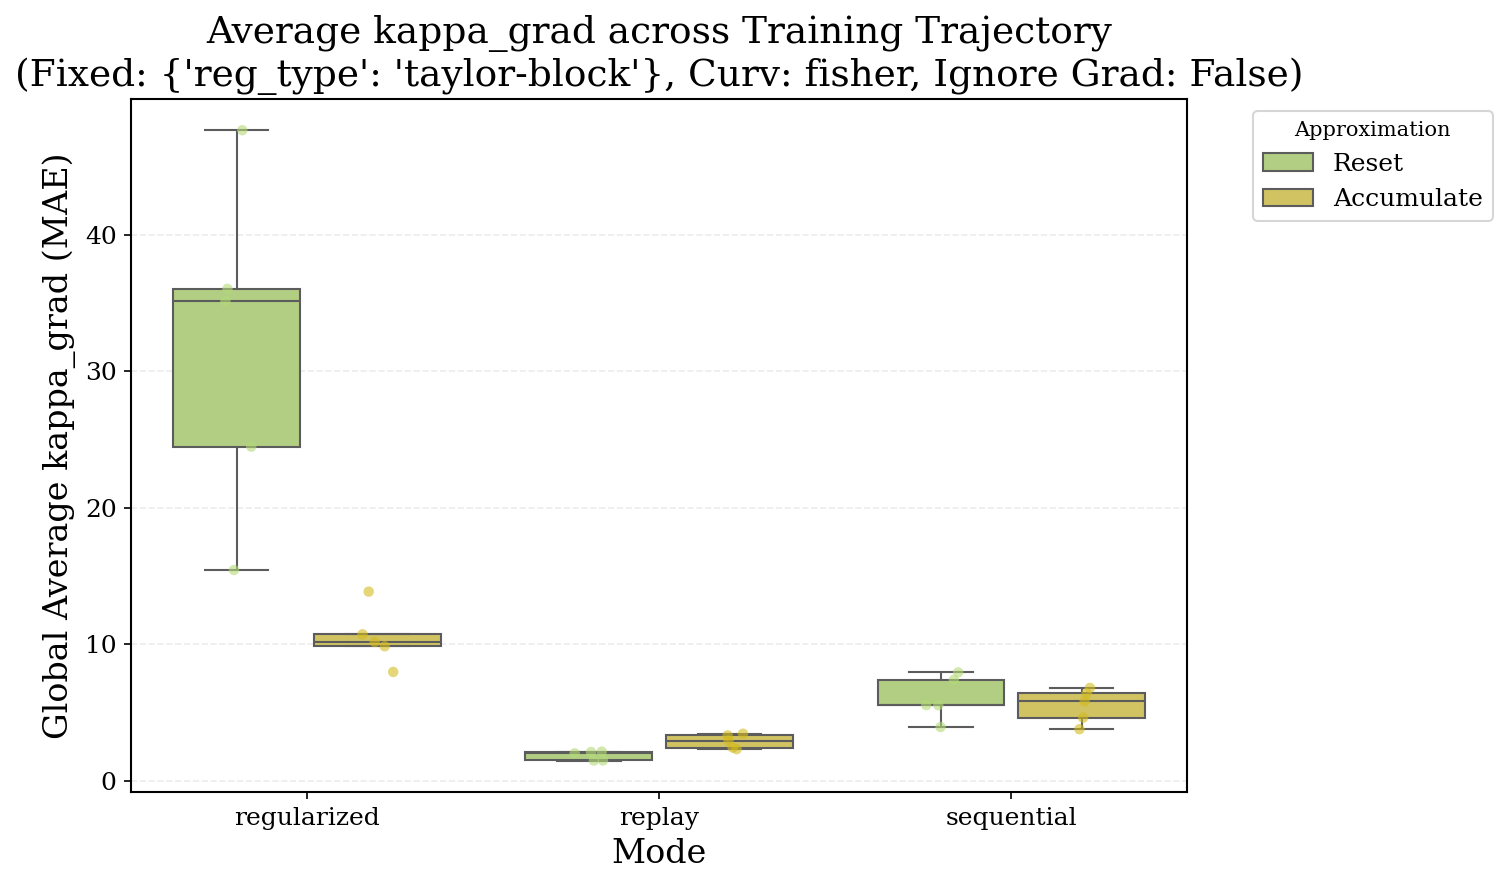

In [23]:


plot_summary_boxplot(
    ROOT_DIR,
    metric='kappa_grad',
    compare_by='mode',      # <--- X-Axis: Hessian vs Fisher
    fixed_params={'reg_type': 'taylor-full'},
    ignore_gradient=False,
    curvature='fisher'
)


plot_summary_boxplot(
    ROOT_DIR,
    metric='kappa_grad',
    compare_by='mode',      # <--- X-Axis: Hessian vs Fisher
    fixed_params={'reg_type': 'taylor-diag'},
    ignore_gradient=False,
    curvature='fisher'
)


plot_summary_boxplot(
    ROOT_DIR,
    metric='kappa_grad',
    compare_by='mode',      # <--- X-Axis: Hessian vs Fisher
    fixed_params={'reg_type': 'taylor-block'},
    ignore_gradient=False,
    curvature='fisher'
)

Indexing 91 experiments...
Aggregating 10 experiments...


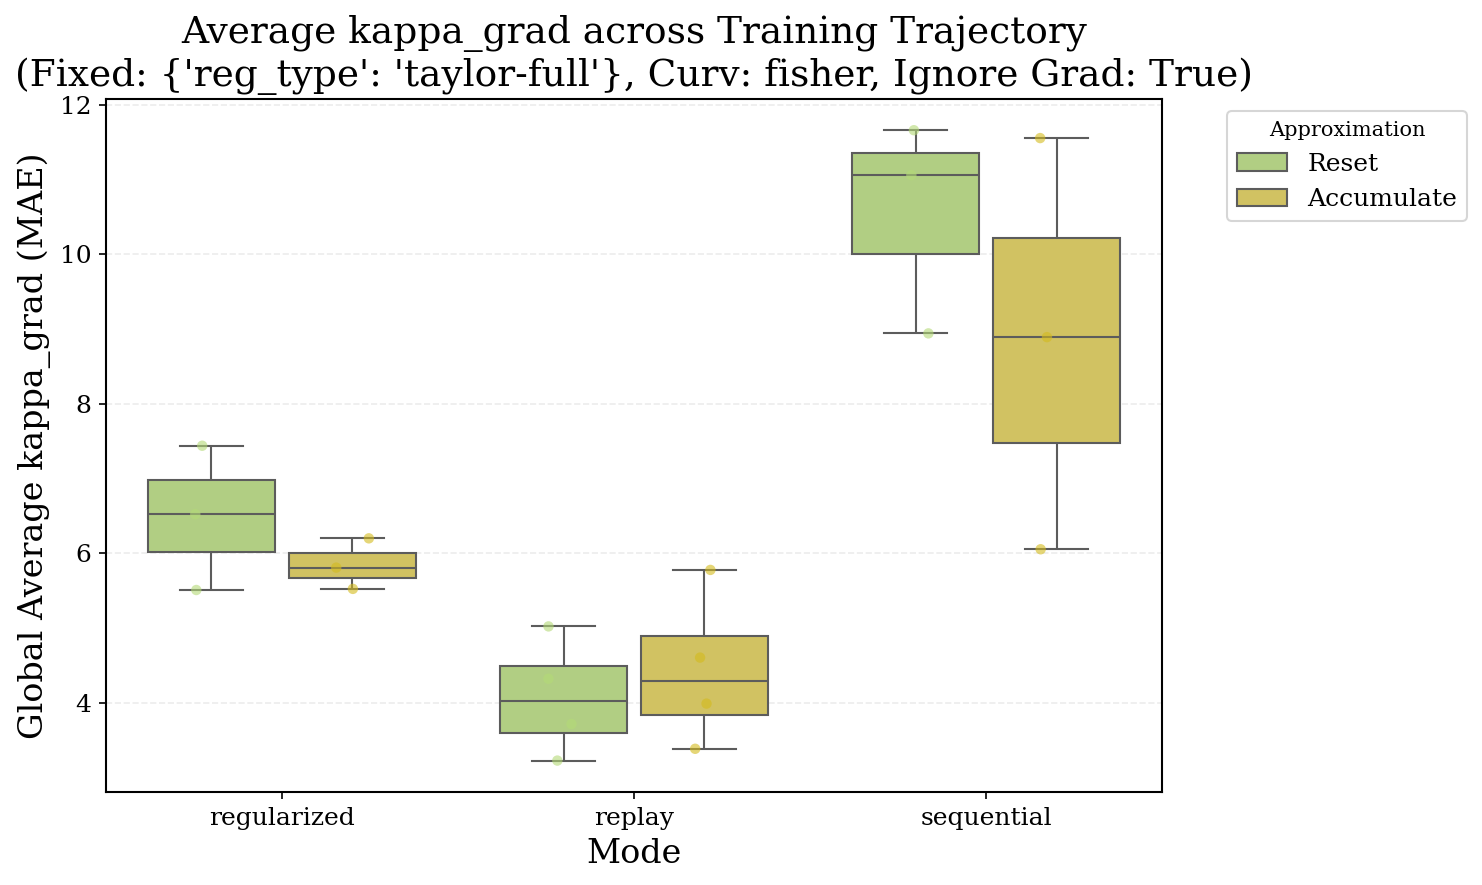

In [53]:
plot_summary_boxplot(
    ROOT_DIR,
    metric='kappa_grad',
    compare_by='mode',      # <--- X-Axis: Hessian vs Fisher
    fixed_params={'reg_type': 'taylor-full'},
    ignore_gradient=True,
    curvature='fisher'
)

Indexing 91 experiments...
Aggregating 10 experiments...


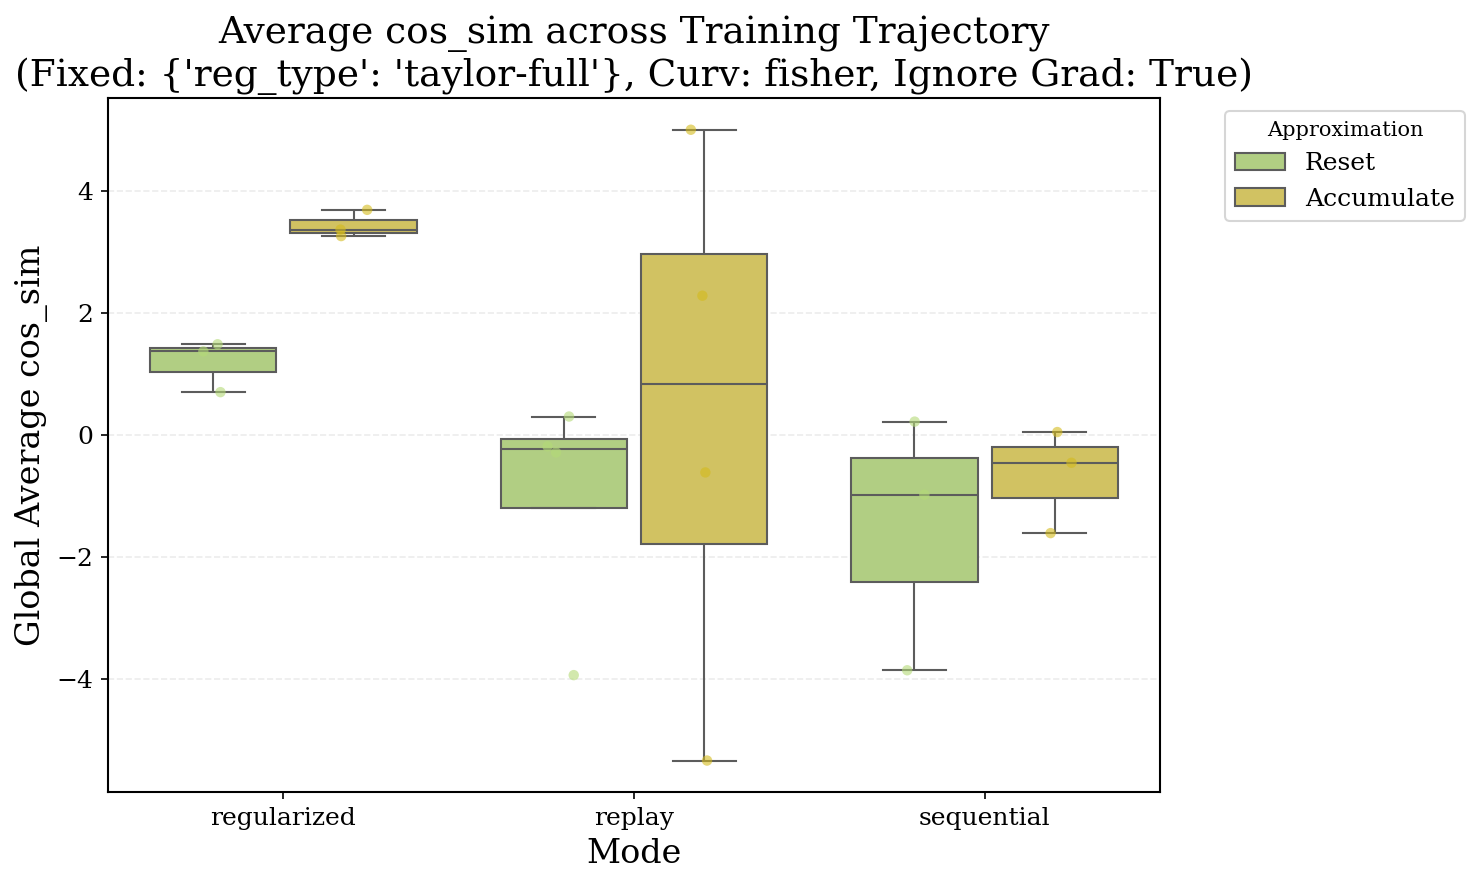

In [55]:
plot_summary_boxplot(
    ROOT_DIR,
    metric='cos_sim',
    compare_by='mode',      # <--- X-Axis: Hessian vs Fisher
    fixed_params={'reg_type': 'taylor-full'},
    ignore_gradient=True,
    curvature='fisher'
)

### Plot specific experiments

In [24]:
def extract_trajectory_series(results, config, metric_root, sample_ids='mean', use_abs=False):
    """
    Extracts time series data. Handles both split metrics (kappa_loss_acc/res) 
    and shared metrics (accuracy).
    """
    num_tasks = config['environment_args']['num_tasks']
    num_steps = config['num_steps']
    if metric_root in L_metrics: 
        keyword = 'landscape'
    elif metric_root in P_metrics:
        keyword = "performance"
    else: keyword = 'history'
    
    # 1. Determine Keys
    # If metric is 'accuracy', it exists as a single key, so we use it for both lines
    if metric_root in L_metrics or metric_root in P_metrics: 
        key_acc = metric_root
        key_res = metric_root
    else:
        key_acc = f"{metric_root}_acc"
        key_res = f"{metric_root}_res"
    
    steps_axis = []
    vals_acc = []
    vals_res = []
    
    curr_step = 0
    
    # Helper to get value safely
    def get_val(d, k):
        v = d.get(k, np.nan)
        if use_abs and not np.isnan(v): return abs(v)
        return v

    for t in range(1, num_tasks):
        if t not in results or keyword not in results[t]:
            curr_step += num_steps
            continue
            
        history = results[t][keyword]
        task_x = np.linspace(0, num_steps, len(history))
        
        for i, step_data in enumerate(history):
            steps_axis.append(curr_step + task_x[i])
            
            step_v_a = []
            step_v_r = []

            
            # Collection Logic
            if sample_ids == 'mean':
                if keyword=="history": 
                    for s_stat in step_data:
                        step_v_a.append(get_val(s_stat, key_acc))
                        step_v_r.append(get_val(s_stat, key_res))
                else: 
                    # the value is already the average 
                    step_v_a = [get_val(step_data, key_acc)]
                    step_v_r = [get_val(step_data, key_res)]
            elif isinstance(sample_ids, list):
                for s_id in sample_ids:
                    if len(step_data) > s_id:
                        step_v_a.append(get_val(step_data[s_id], key_acc))
                        step_v_r.append(get_val(step_data[s_id], key_res))
            
            
            # Aggregation (Mean across samples for this time step)
            vals_acc.append(np.nanmean(step_v_a))
            vals_res.append(np.nanmean(step_v_r))

        curr_step += num_steps
        
    return np.array(steps_axis), np.array(vals_acc), np.array(vals_res)

In [25]:
def plot_specific_experiment(root_dir, 
                             metric='kappa_loss',
                             # --- Configuration Filters ---
                             seed=None, # <--- None = Aggregate all seeds
                             mode='regularized',
                             reg_type='taylor-diag',
                             alpha=1.0,
                             curvature='hessian',
                             ignore_gradient=False,
                             # --- Plotting Options ---
                             sample_ids='mean',
                             use_abs=None):
    """
    Finds experiment(s) matching the configuration.
    If seed is an int, plots that specific run.
    If seed is None, aggregates ALL matching seeds (Mean +/- Std).
    """
    
    # 1. Auto-detect settings
    if use_abs is None:
        use_abs = True if 'kappa' in metric else False

    # 2. Search Index
    index = get_experiment_index(root_dir)
    matches = []
    
    print(f"Searching for: {mode} | {reg_type} | {curvature} | Alpha={alpha} | Grad={not ignore_gradient} ...")
    
    for item in index:
        # Check all params except seed
        if (item['mode'] == mode and 
            item['reg_type'] == reg_type and 
            item['curvature'] == curvature and 
            item.get('alpha') == alpha and
            item.get('ignore_gradient', False) == ignore_gradient):
            
            # If a specific seed is requested, check it
            if seed is not None:
                if item['seed'] == seed:
                    matches.append(item)
            else:
                # Otherwise keep all seeds
                matches.append(item)

    if not matches:
        print("❌ No experiments found! Check your parameters.")
        return

    print(f"Found {len(matches)} matching seeds. Processing...")

    # 3. Load & Extract Data
    acc_list = [] # List of arrays (one per seed)
    res_list = []
    steps_ref = None
    last_config = None # Needed for task boundaries
    
    for m in matches:
        try:
            results = torch.load(m['metrics_path'], map_location='cpu', weights_only=False)
            last_config = m['config']
            
            steps, v_acc, v_res = extract_trajectory_series(
                results, last_config, metric, sample_ids, use_abs
            )
            
            # Handle potential length mismatches (truncate to shortest)
            if steps_ref is None:
                steps_ref = steps
            elif len(steps) != len(steps_ref):
                mn = min(len(steps), len(steps_ref))
                steps = steps[:mn]; v_acc = v_acc[:mn]; v_res = v_res[:mn]
                steps_ref = steps_ref[:mn]
                # Truncate existing lists
                acc_list = [x[:mn] for x in acc_list]
                res_list = [x[:mn] for x in res_list]
            
            acc_list.append(v_acc)
            res_list.append(v_res)
            
        except Exception as e:
            print(f"Error reading seed {m['seed']}: {e}")
            continue

    if not acc_list:
        print("Data extraction failed.")
        return

    # 4. Calculate Statistics (Mean & Std)
    # Stack into (Num_Seeds, Num_Steps)|
    mat_acc = np.vstack(acc_list)
    mat_res = np.vstack(res_list)
    
    mean_acc = np.nanmean(mat_acc, axis=0)
    std_acc  = np.nanstd(mat_acc, axis=0)
    
    mean_res = np.nanmean(mat_res, axis=0)
    std_res  = np.nanstd(mat_res, axis=0)

    # 5. Plot
    plt.figure(figsize=(12, 5), dpi=150)
    
    if metric in L_metrics or metric in P_metrics:
        # Single line case
        plt.plot(steps_ref, mean_acc, color='black', lw=2, label=f'Model {metric} (N={len(matches)})')
        plt.fill_between(steps_ref, mean_acc - std_acc, mean_acc + std_acc, color='gray', alpha=0.2)
    else:
        # Dual line case (Accum vs Reset)
        # Plot Accumulate
        plt.plot(steps_ref, mean_acc, color='#d62728', linestyle='-', lw=2, label='Accumulate')
        plt.fill_between(steps_ref, mean_acc - std_acc, mean_acc + std_acc, color='#d62728', alpha=0.15)
        
        # Plot Reset
        plt.plot(steps_ref, mean_res, color='#1f77b4', linestyle='--', lw=2, label='Reset')
        plt.fill_between(steps_ref, mean_res - std_res, mean_res + std_res, color='#1f77b4', alpha=0.15)

    # Add Task Boundaries
    num_tasks = last_config['environment_args']['num_tasks']
    num_steps = last_config['num_steps']
    
    # Smart Y-Limit
    max_y = max(np.nanmax(mean_acc + std_acc), np.nanmax(mean_res + std_res))
    if use_abs: plt.ylim(0, 10)
    # plt.ylim(0, 100)

    for t in range(1, num_tasks):
        x_pos = t * num_steps
        plt.axvline(x=x_pos, color='gray', linestyle=':', alpha=0.5)
        # Label tasks
        if t < num_tasks:
            plt.text(x_pos - (num_steps/2), plt.ylim()[1], f"Task {t+1}", 
                     ha='center', va='top', fontsize=8, color='gray', backgroundcolor='white')

    # Formatting
    seed_str = f"Avg of {len(matches)} Seeds" if seed is None else f"Seed {seed}"
    title_str = (f"Trajectory: {metric} {'(MAE)' if use_abs else ''}\n"
                 f"[{reg_type}, {curvature}, $\\alpha={alpha}$, Grad={not ignore_gradient}, {seed_str}]")
    
    plt.title(title_str, fontsize=14)
    plt.xlabel("Global Training Steps", fontsize=12)
    plt.ylabel(metric.replace('_', ' ').title(), fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend(loc='upper left', frameon=True)
    
    plt.tight_layout()
    plt.show()

Indexing 98 experiments...
Searching for: replay | taylor-full | fisher | Alpha=1 | Grad=False ...
Found 3 matching seeds. Processing...


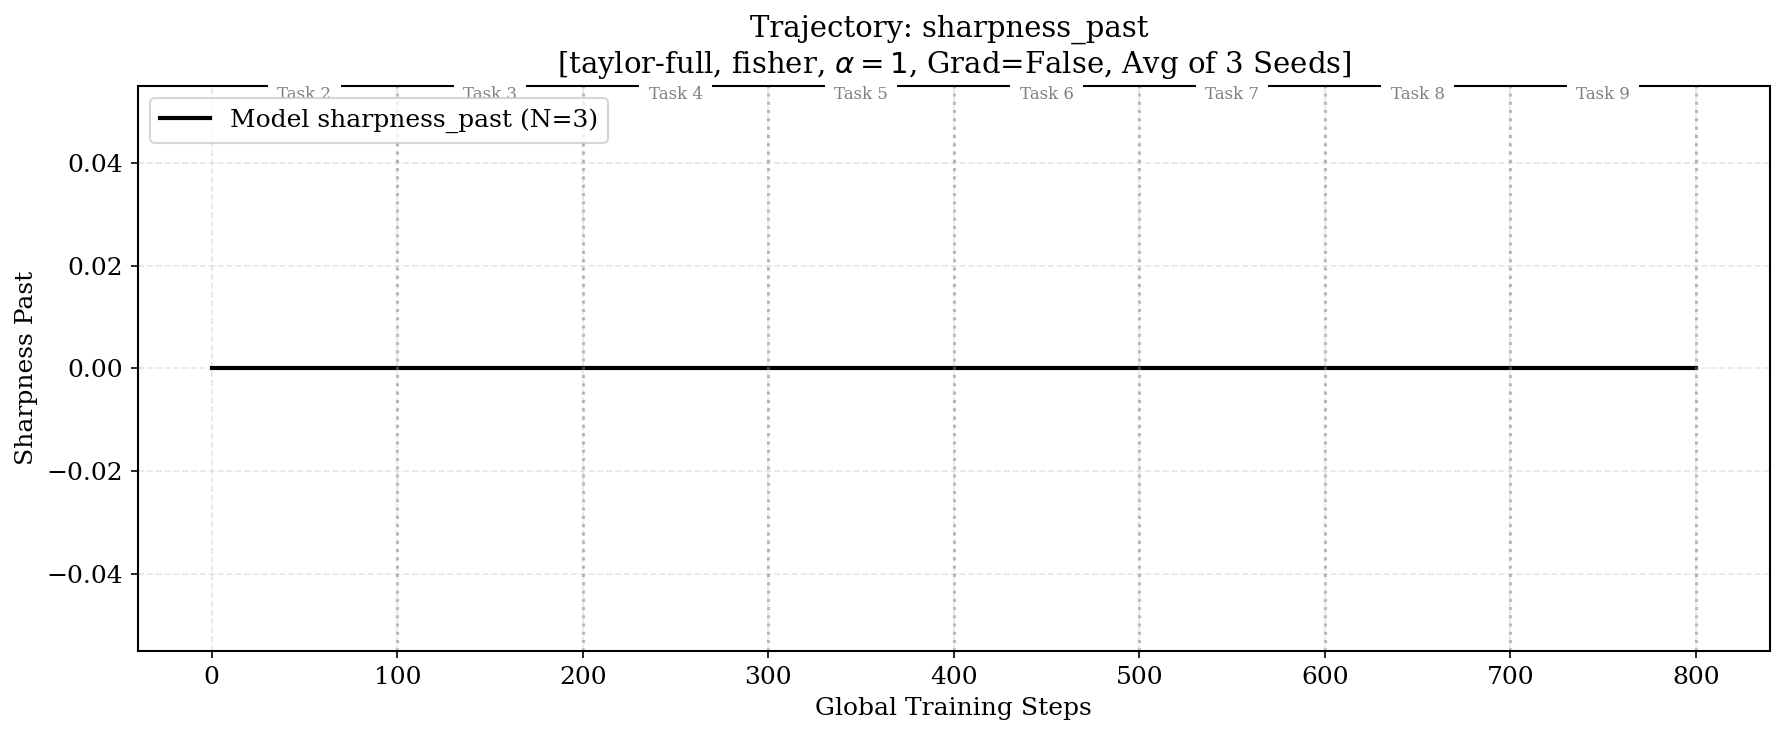

Indexing 98 experiments...
Searching for: sequential | taylor-full | fisher | Alpha=1 | Grad=False ...
Found 3 matching seeds. Processing...


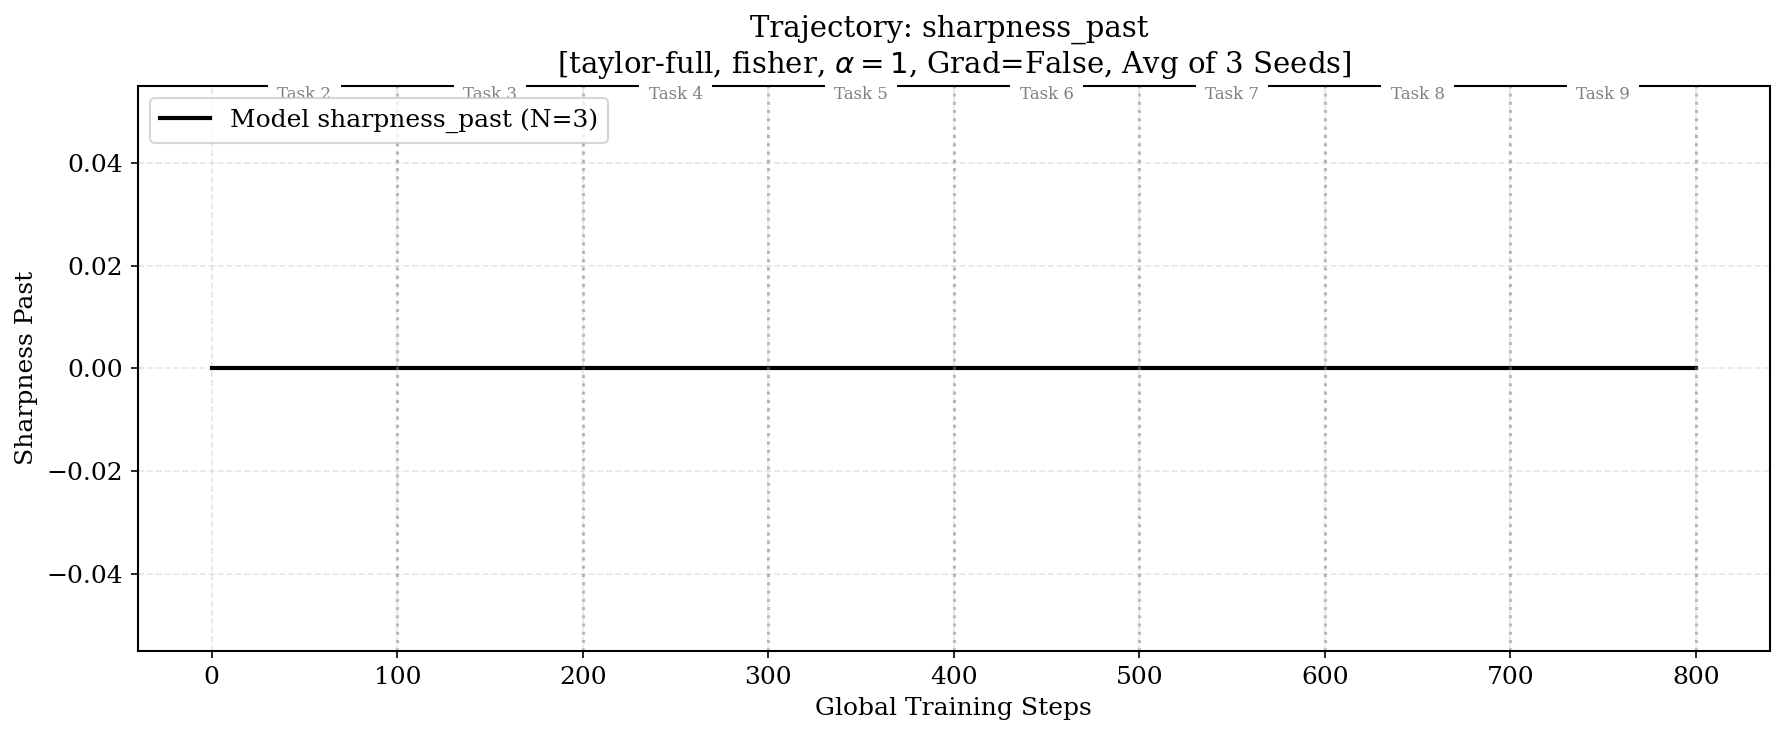

Indexing 98 experiments...
Searching for: regularized | taylor-full | fisher | Alpha=1 | Grad=False ...
Found 3 matching seeds. Processing...


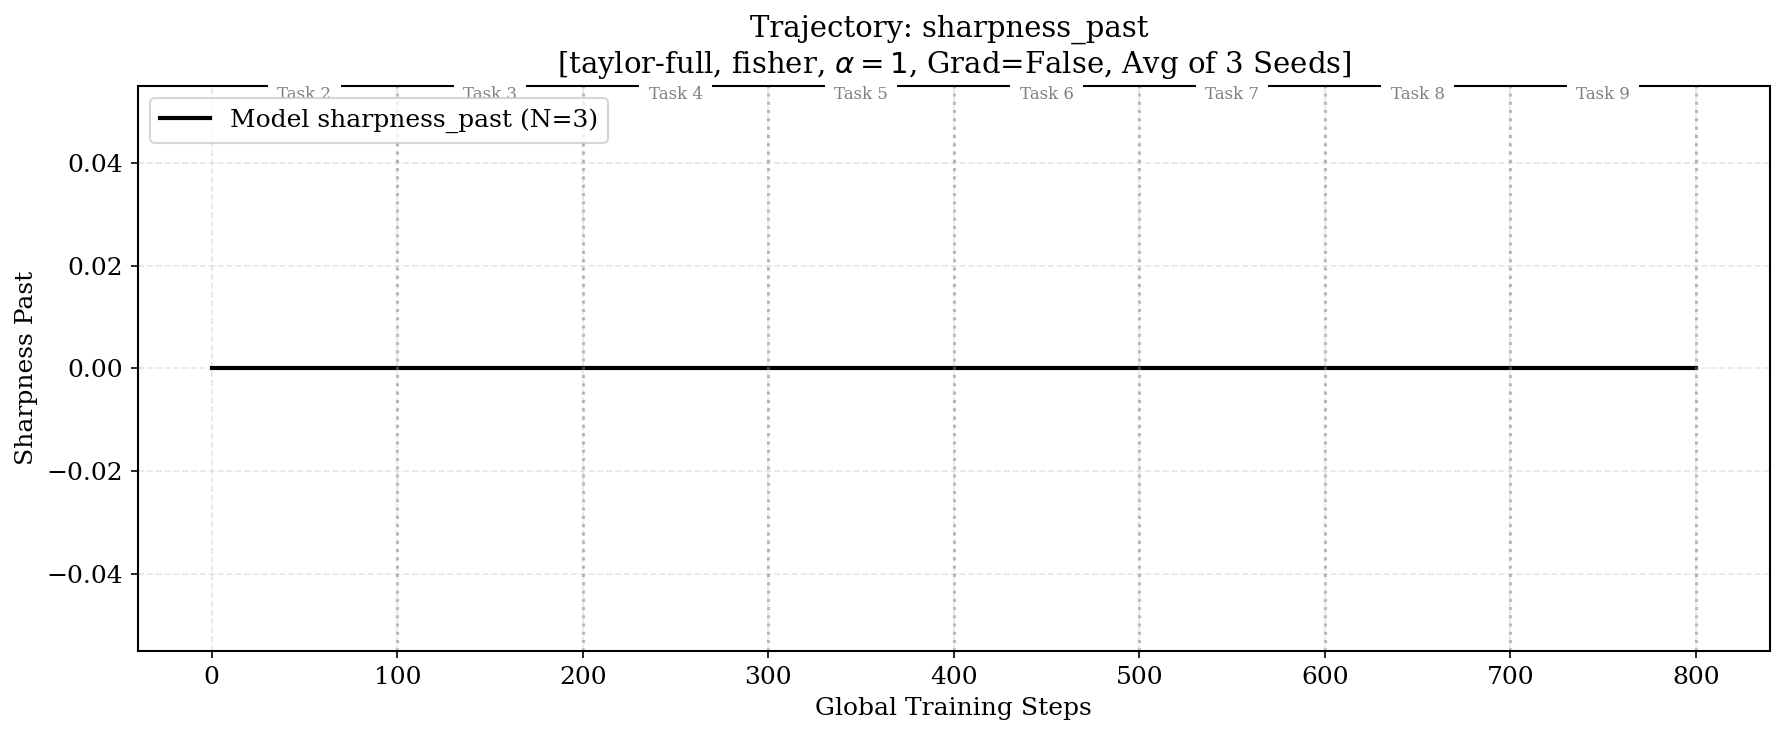

In [72]:
plot_specific_experiment(
    ROOT_DIR,
    metric='sharpness_past',
    reg_type='taylor-full',
    mode='replay',
    curvature='fisher',
    ignore_gradient=True,
    alpha=1,
    seed=None # <--- Triggers aggregation
)

plot_specific_experiment(
    ROOT_DIR,
    metric='sharpness_past',
    reg_type='taylor-full',
    mode='sequential',
    curvature='fisher',
    ignore_gradient=True,
    alpha=1,
    seed=None # <--- Triggers aggregation
)

plot_specific_experiment(
    ROOT_DIR,
    metric='sharpness_past',
    reg_type='taylor-full',
    mode='regularized',
    curvature='fisher',
    ignore_gradient=True,
    alpha=1,
    seed=None # <--- Triggers aggregation
)

Indexing 97 experiments...
Searching for: regularized | taylor-full | fisher | Alpha=1 | Grad=False ...
Found 3 matching seeds. Processing...


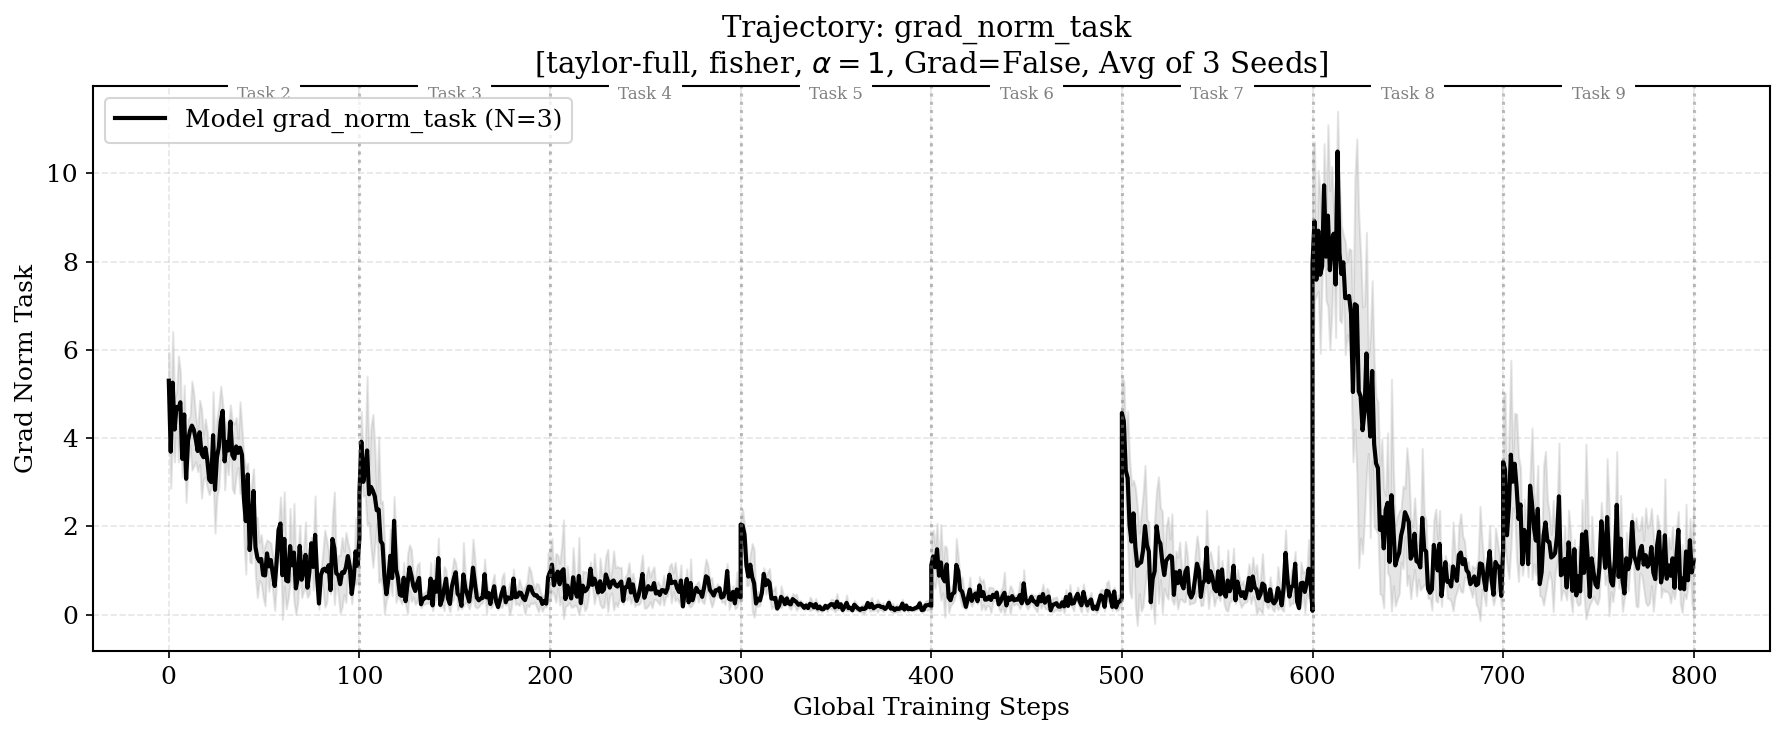

Indexing 97 experiments...
Searching for: regularized | taylor-full | fisher | Alpha=1 | Grad=False ...
Found 3 matching seeds. Processing...


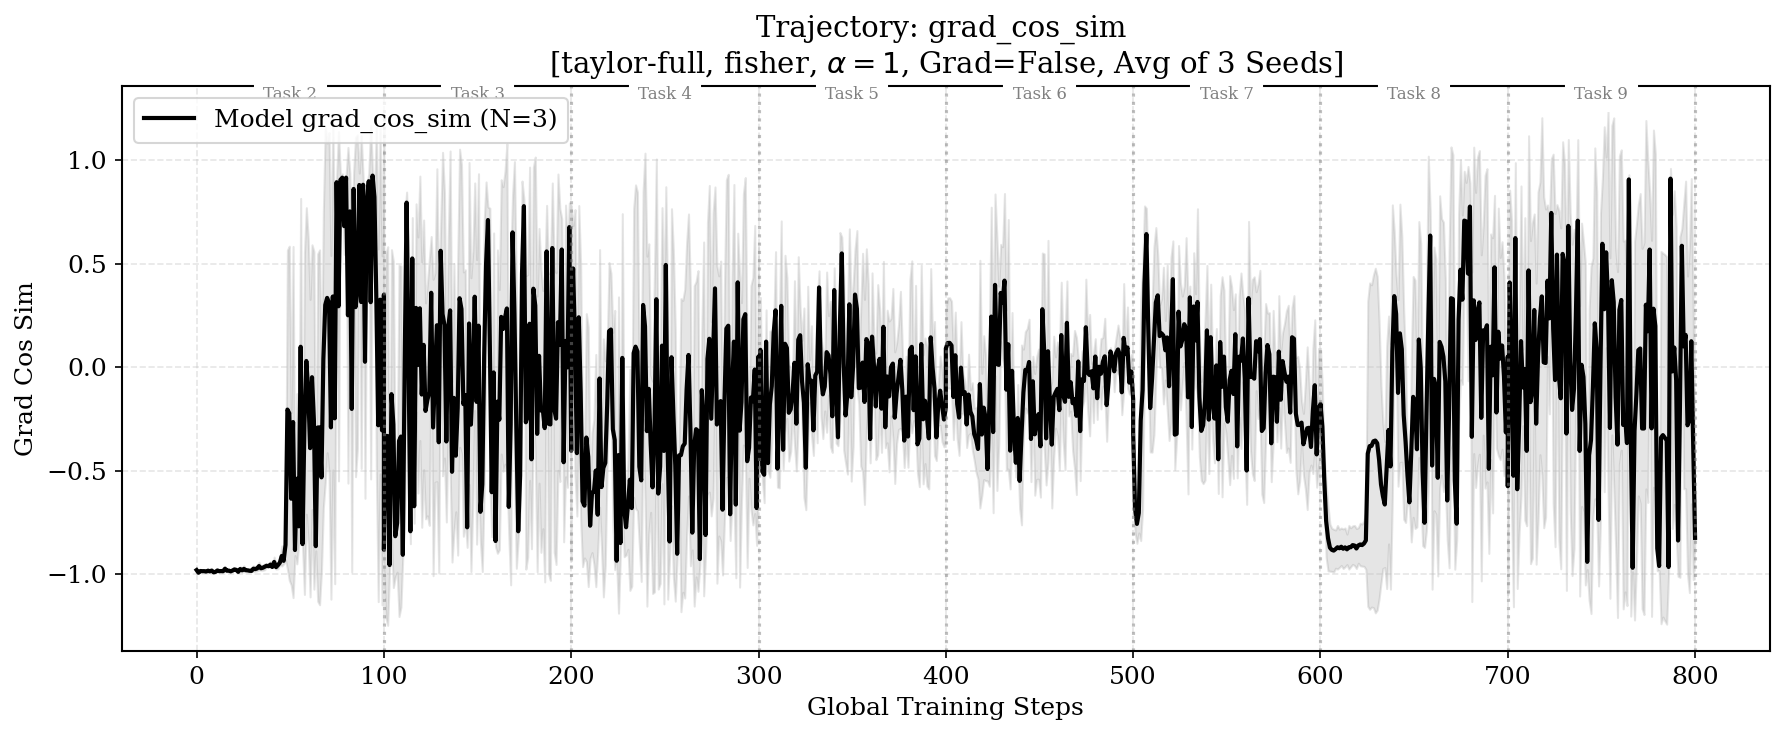

In [76]:
plot_specific_experiment(
    ROOT_DIR,
    metric='grad_norm_task',
    reg_type='taylor-full',
    mode='regularized',
    curvature='fisher',
    ignore_gradient=True,
    alpha=1,
    seed=None # <--- Triggers aggregation
)
plot_specific_experiment(
    ROOT_DIR,
    metric='grad_cos_sim',
    reg_type='taylor-full',
    mode='regularized',
    curvature='fisher',
    ignore_gradient=True,
    alpha=1,
    seed=None # <--- Triggers aggregation
)



Indexing 98 experiments...
Searching for: regularized | taylor-full | fisher | Alpha=1 | Grad=False ...
Found 3 matching seeds. Processing...


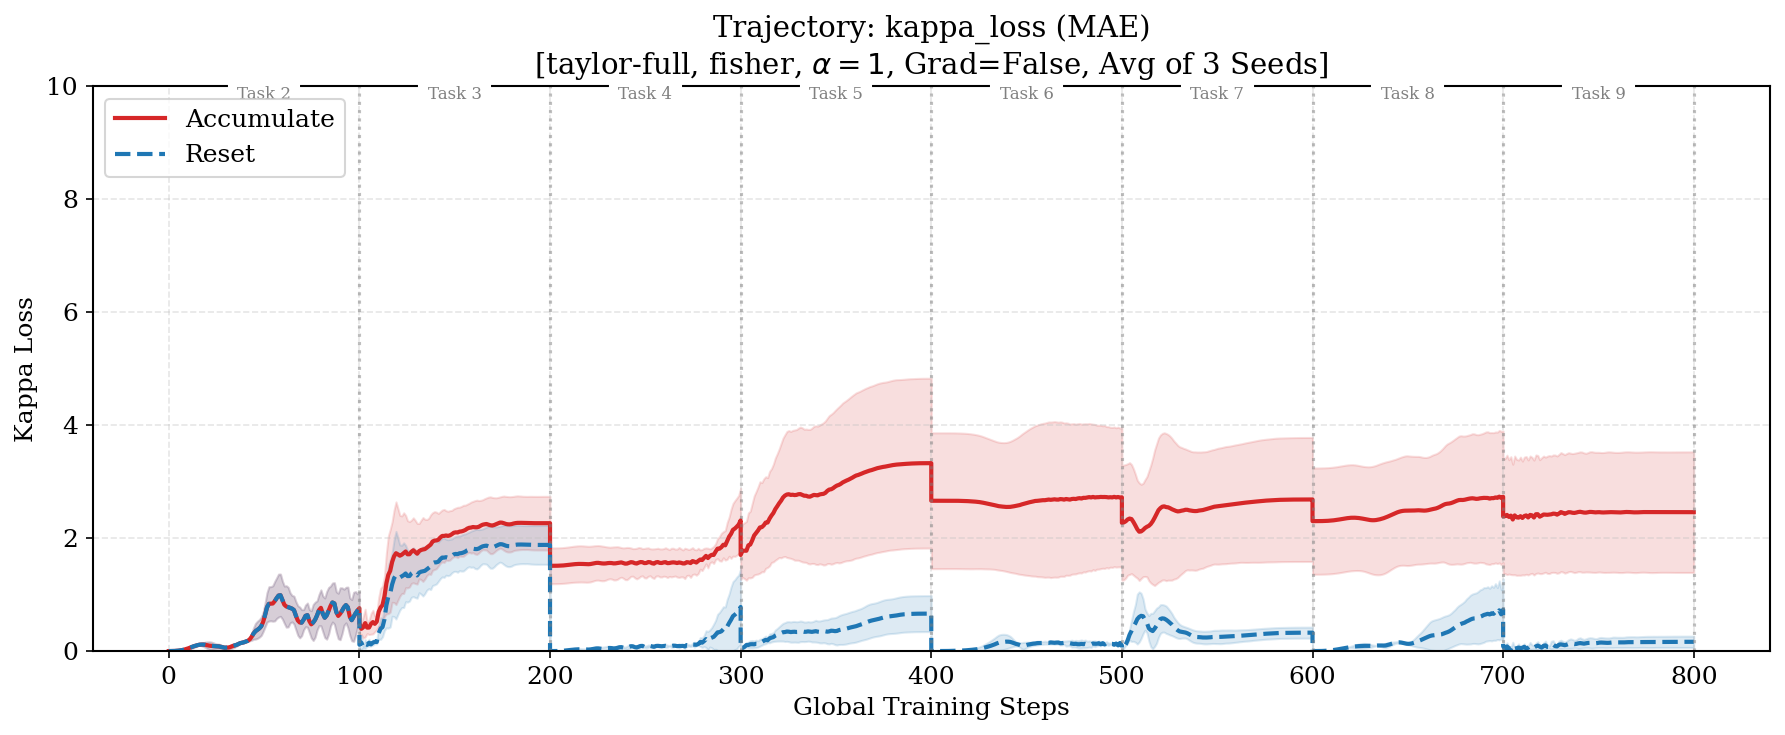

Indexing 98 experiments...
Searching for: regularized | taylor-block | fisher | Alpha=1 | Grad=False ...
Found 3 matching seeds. Processing...


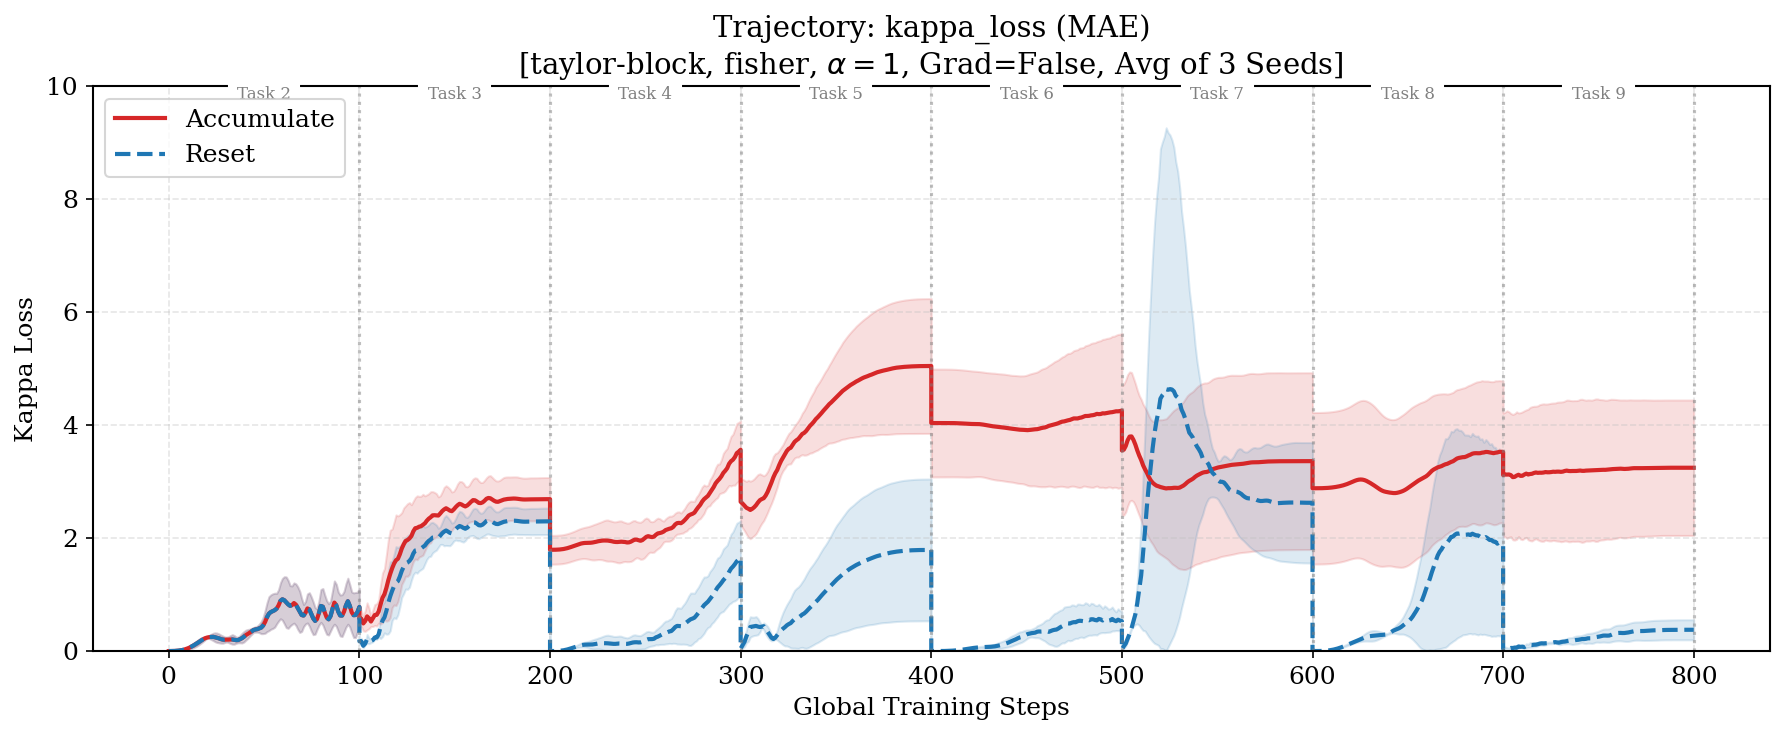

Indexing 98 experiments...
Searching for: regularized | taylor-diag | fisher | Alpha=1 | Grad=False ...
Found 3 matching seeds. Processing...


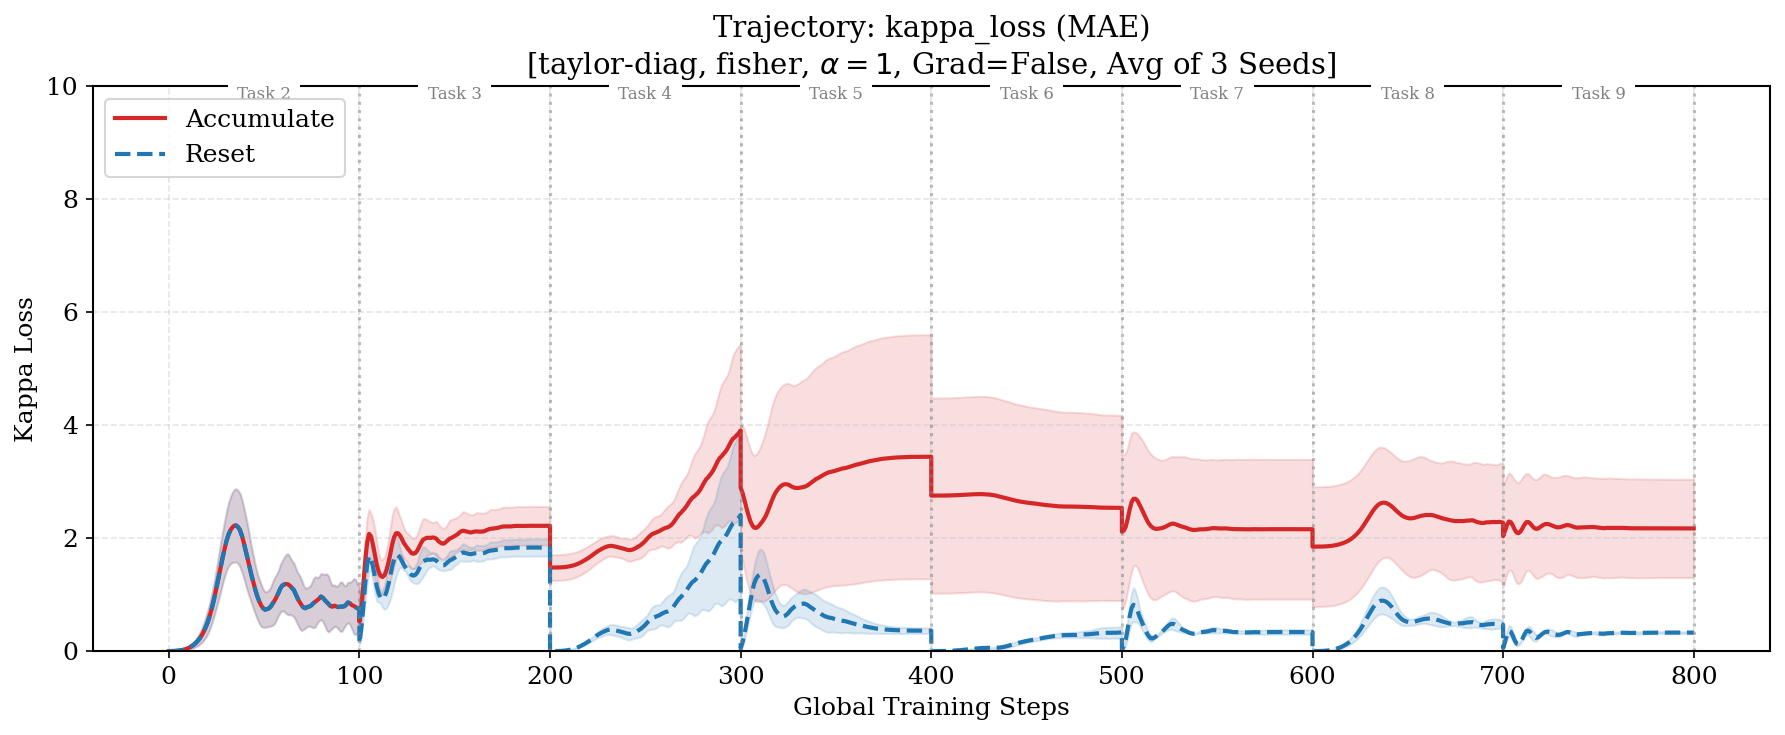

In [20]:
plot_specific_experiment(
    ROOT_DIR,
    metric='kappa_loss',
    reg_type='taylor-full',
    mode='regularized',
    curvature='fisher',
    ignore_gradient=True,
    alpha=1,
    seed=None # <--- Triggers aggregation
)
plot_specific_experiment(
    ROOT_DIR,
    metric='kappa_loss',
    reg_type='taylor-block',
    mode='regularized',
    curvature='fisher',
    ignore_gradient=True,
    alpha=1,
    seed=None # <--- Triggers aggregation
)
plot_specific_experiment(
    ROOT_DIR,
    metric='kappa_loss',
    reg_type='taylor-diag',
    mode='regularized',
    curvature='fisher',
    ignore_gradient=True,
    alpha=1,
    seed=None # <--- Triggers aggregation
)

# Analysis of the alignment hypothesis 

In [44]:
def extract_geometry_series(results, config, metric_key, rank_idx=0, smooth_window=1):
    """
    Extracts a time series for a specific eigenvector rank.
    metric_key: 'alignments_with_top_eigs' OR 'projections_along_top_eigs'
    """
    num_tasks = config['environment_args']['num_tasks']
    num_steps = config['num_steps']
    
    steps_axis = []
    values = []
    curr_step = 0
    
    for t in range(1, num_tasks):
        if t not in results or metric_key not in results[t]:
            # Fill gaps to keep timeline consistent
            dummy_steps = np.linspace(0, num_steps, num_steps)
            steps_axis.extend(curr_step + dummy_steps)
            values.extend([np.nan] * len(dummy_steps))
            curr_step += num_steps
            continue
            
        raw_history = results[t][metric_key]
        actual_steps = len(raw_history)
        task_x = np.linspace(0, num_steps, actual_steps)
        
        for i, scores in enumerate(raw_history):
            steps_axis.append(curr_step + task_x[i])
            # Extract Rank
            val = 0.0
            if isinstance(scores, list) and len(scores) > rank_idx:
                val = scores[rank_idx]
            elif isinstance(scores, (float, np.floating)):
                val = scores # Fallback if scalar
                
            # If projection, we usually want magnitude for cleaner plots
            if 'projection' in metric_key:
                val = abs(val)
                
            values.append(val)

        curr_step += num_steps
        
    # Smoothing (Optional, mostly for Alignment which is noisy)
    vals_arr = np.array(values)
    if smooth_window > 1 and len(vals_arr) > smooth_window:
        kernel = np.ones(smooth_window) / smooth_window
        vals_arr = np.convolve(np.nan_to_num(vals_arr), kernel, mode='same')
        
    return np.array(steps_axis), vals_arr

In [47]:
def plot_geometry_analysis(root_dir, 
                           ranks_to_plot=[0, 4, 9], # e.g. Rank 1, 5, 10
                           # --- Filters ---
                           seed=None, # None=Aggregate, Int=Specific
                           mode='regularized',
                           reg_type='taylor-full',
                           curvature='fisher',
                           alpha=1.0,
                           ignore_gradient=False,
                           # --- Visuals ---
                           smooth_align=50):
    
    index = get_experiment_index(root_dir)
    matches = []
    for item in index:
        if (item['mode'] == mode and 
            item['reg_type'] == reg_type and 
            item['curvature'] == curvature and 
            item.get('alpha') == alpha and
            item.get('ignore_gradient', False) == ignore_gradient):
            
            if seed is not None and item['seed'] != seed: continue
            matches.append(item)
            
    if not matches:
        print("No matching experiments found.")
        return

    print(f"Plotting Geometry Analysis for {len(matches)} seeds...")

    # Setup 2 Subplots
    fig, axes = plt.subplots(2, 1, figsize=(10, 10), dpi=300)
    
    # Define Colors (Rank 1 = Dark Purple, Rank N = Yellow)
    colors = plt.cm.viridis(np.linspace(0, 0.9, len(ranks_to_plot)))
    
    metrics = [
        ('alignments_with_top_eigs', axes[0], 'Optimizer Alignment (Velocity)', 0.0, 1.0, smooth_align),
        ('projections_along_top_eigs', axes[1], 'Cumulative Drift (Position)', 0.0, None, 1) # No smoothing for drift
    ]

    for metric_key, ax, title, y_min, y_max, smooth in metrics:
        
        for i, rank_idx in enumerate(ranks_to_plot):
            color = colors[i]
            
            # Aggregate across seeds
            all_series = []
            steps_ref = None
            
            for m in matches:
                try:
                    res = torch.load(m['metrics_path'], map_location='cpu', weights_only=False)
                    steps, vals = extract_geometry_series(res, m['config'], metric_key, rank_idx, smooth)
                    
                    if steps_ref is None: steps_ref = steps
                    elif len(steps) != len(steps_ref):
                        mn = min(len(steps), len(steps_ref))
                        steps = steps[:mn]; vals = vals[:mn]
                        steps_ref = steps_ref[:mn]
                        all_series = [x[:mn] for x in all_series]
                        
                    all_series.append(vals)
                except: continue
                
            if not all_series: continue
            
            # Stats
            mat = np.vstack(all_series)
            mean_line = np.nanmean(mat, axis=0)
            
            # Plot Line
            ax.plot(steps_ref, mean_line, color=color, lw=2, label=f"Rank {rank_idx+1}")
            
            # Shading (only if aggregating)
            if seed is None and len(matches) > 1:
                std_line = np.nanstd(mat, axis=0)
                ax.fill_between(steps_ref, mean_line-std_line, mean_line+std_line, color=color, alpha=0.1)

        # Formatting per subplot
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel("Global Steps")
        # if y_max is not None: ax.set_ylim(y_min, y_max)
        # else: ax.set_ylim(bottom=y_min) # Auto-scale max for drift
        
        # Task Boundaries
        if matches:
            cfg = matches[0]['config']
            for t in range(1, cfg['environment_args']['num_tasks']):
                ax.axvline(x=t*cfg['num_steps'], color='gray', ls=':', alpha=0.3)
        
        ax.grid(True, alpha=0.3)

    # Legend (Shared)
    axes[1].legend(loc='upper right', title="Eigenvector Rank\n(High Curv $\\to$ Low)")
    
    # Main Title
    seed_txt = f"Seed {seed}" if seed is not None else f"Avg {len(matches)} Seeds"
    fig.suptitle(f"Geometry Analysis: {mode} | {reg_type} | {curvature} | {seed_txt}", fontsize=14)
    
    plt.tight_layout()
    plt.show()

Indexing 98 experiments...
Plotting Geometry Analysis for 1 seeds...


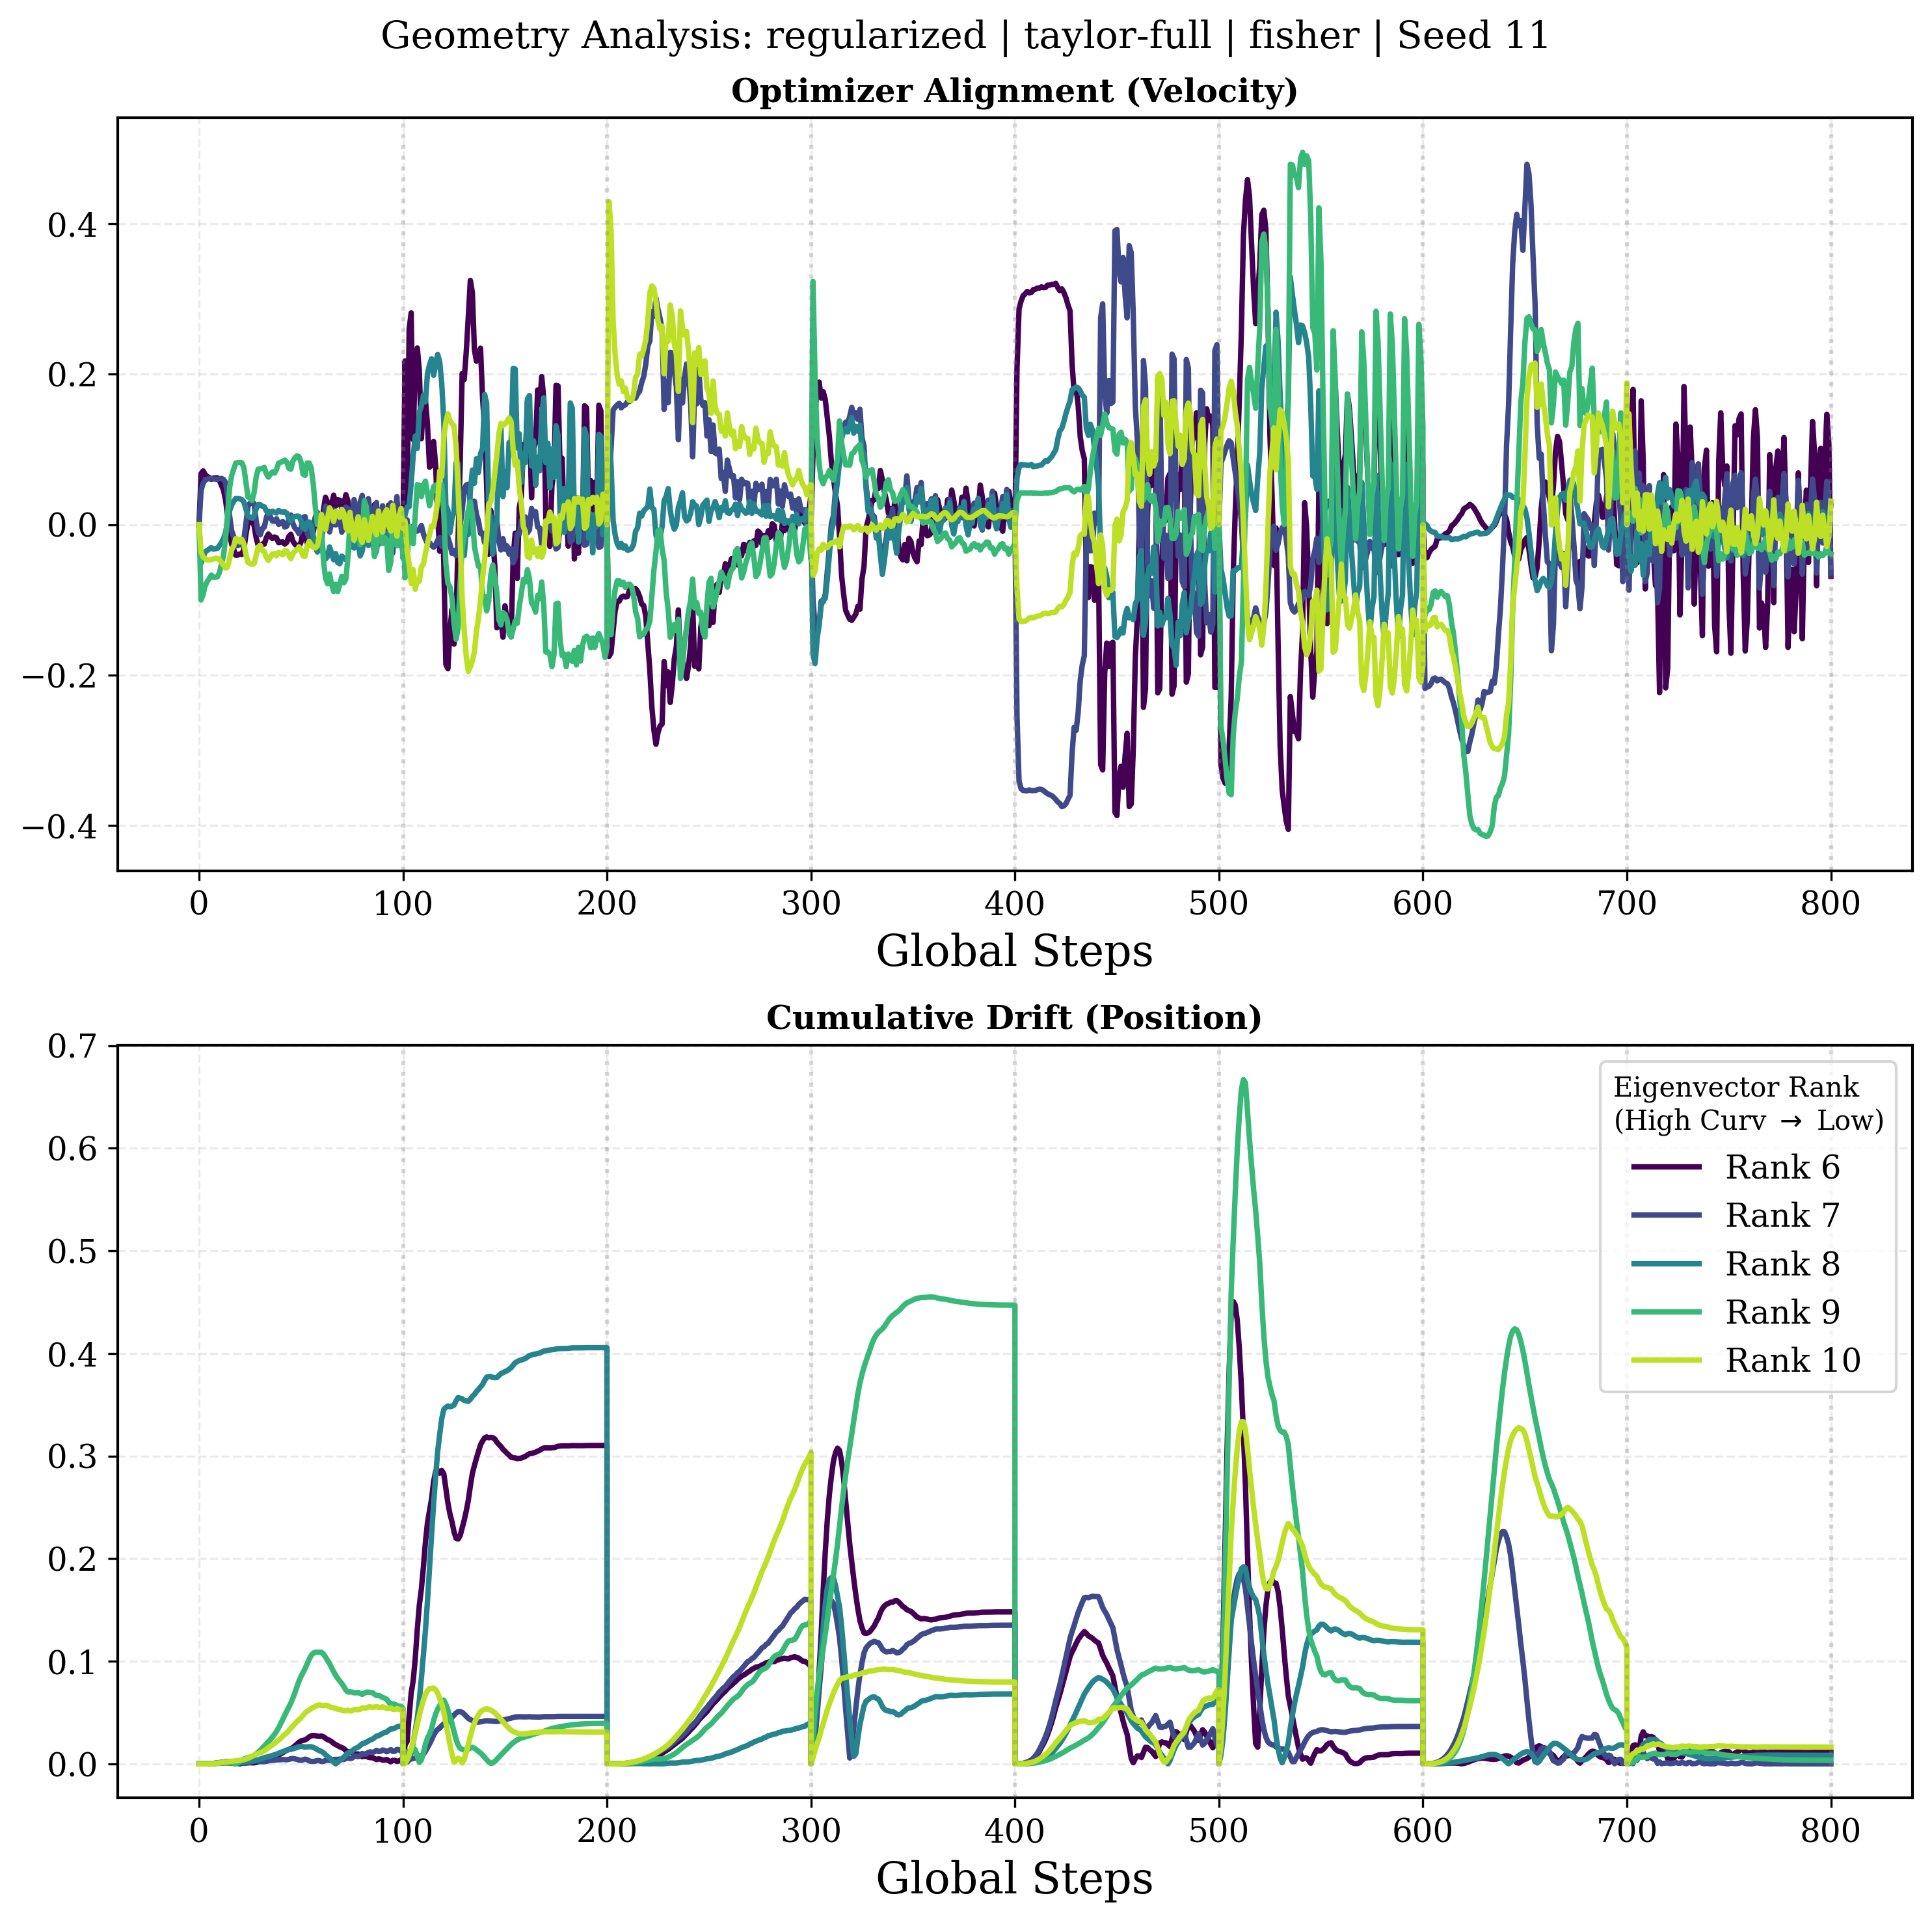

In [65]:
plot_geometry_analysis(
    ROOT_DIR,
    ranks_to_plot=list(range(5,10)), # Top-1, Top-5, Top-10
    mode='regularized',
    reg_type='taylor-full',
    curvature='fisher',
    alpha=1.0,
    seed=11, # Aggregate all seeds,
    ignore_gradient=True,
    smooth_align=1
)

Indexing 98 experiments...
Plotting Geometry Analysis for 1 seeds...


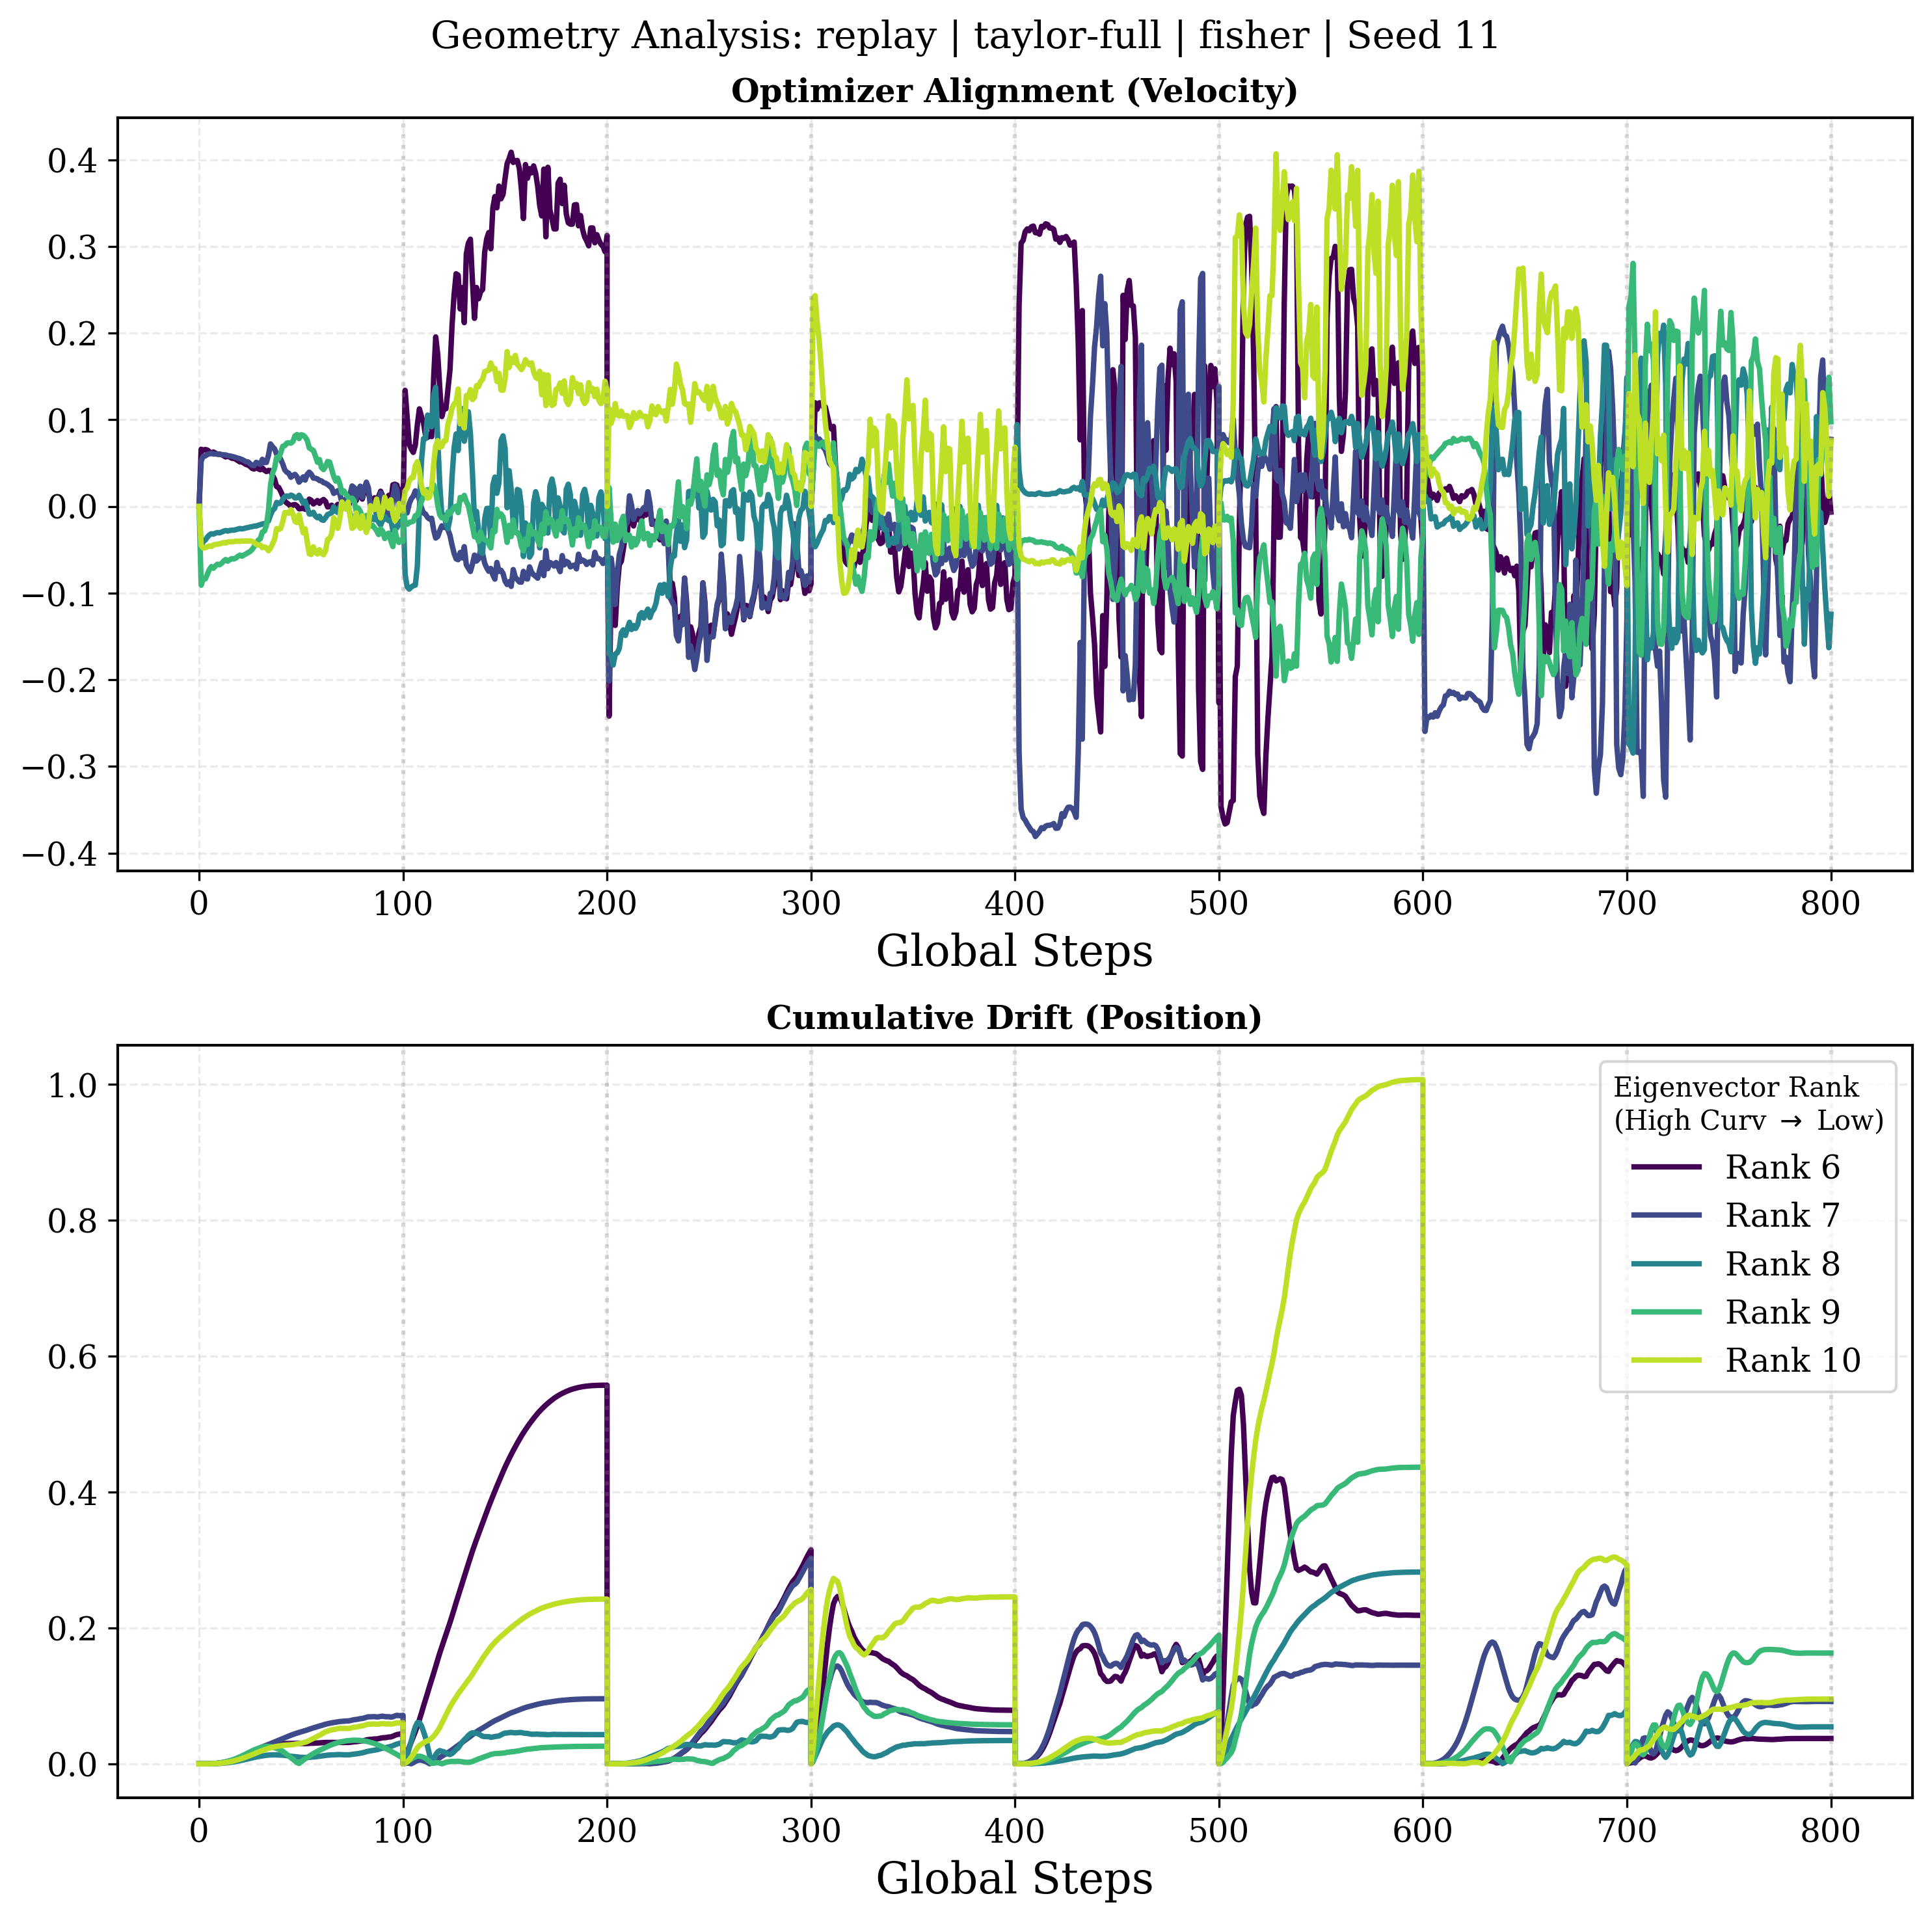

In [67]:
plot_geometry_analysis(
    ROOT_DIR,
    ranks_to_plot=list(range(5,10)), # Top-1, Top-5, Top-10
    mode='replay',
    reg_type='taylor-full',
    curvature='fisher',
    alpha=1.0,
    seed=11, # Aggregate all seeds,
    ignore_gradient=True,
    smooth_align=1
)

In [21]:
def plot_alignment_ranks(root_dir, 
                         ranks_to_plot=[0, 1, 2], 
                         # --- Configuration Filters ---
                         seed=None, # <--- NEW: None = Aggregate, Int = Specific Seed
                         mode='regularized',
                         reg_type='taylor-full',
                         curvature='hessian',
                         ignore_gradient=False,
                         alpha=1.0,
                         smooth_window=50):
    """
    Plots alignment for multiple eigenvector ranks.
    If seed is provided, plots that specific run (no error bars).
    If seed is None, aggregates all matching seeds (Mean +/- Std).
    """
    
    index = get_experiment_index(root_dir)
    
    # 1. Find matching experiments
    matches = []
    for item in index:
        if (item['mode'] == mode and 
            item['reg_type'] == reg_type and 
            item['curvature'] == curvature and 
            item.get('alpha') == alpha and
            item.get('ignore_gradient', False) == ignore_gradient):
            
            # Filter by seed if requested
            if seed is not None:
                if item['seed'] == seed:
                    matches.append(item)
            else:
                matches.append(item)
            
    if not matches:
        print("No matching experiments found.")
        return

    print(f"Found {len(matches)} seeds. Plotting Ranks {ranks_to_plot}...")

    # 2. Setup Plot
    fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
    colors = plt.cm.viridis(np.linspace(0, 0.8, len(ranks_to_plot)))
    
    # 3. Iterate Ranks
    for i, rank_idx in enumerate(ranks_to_plot):
        color = colors[i]
        
        all_series = []
        steps_ref = None
        
        # Aggregate across found seeds
        for m in matches:
            try:
                res = torch.load(m['metrics_path'], map_location='cpu', weights_only=False)
                cfg = m['config']
                
                # Extract specific rank
                steps, vals = extract_alignment_series(res, cfg, rank_idx=rank_idx, smooth_window=smooth_window)
                
                if steps_ref is None: steps_ref = steps
                elif len(steps) != len(steps_ref):
                    mn = min(len(steps), len(steps_ref))
                    steps = steps[:mn]; vals = vals[:mn]
                    steps_ref = steps_ref[:mn]
                    all_series = [x[:mn] for x in all_series]
                    
                all_series.append(vals)
            except: continue
            
        if not all_series: continue
        
        # Compute Stats
        mat = np.vstack(all_series)
        mean_line = np.nanmean(mat, axis=0)
        
        # Plot
        ax.plot(steps_ref, mean_line, color=color, lw=2, label=f"Rank {rank_idx+1}")
        
        # Only add shaded error region if we are aggregating multiple seeds
        if seed is None and len(matches) > 1:
            std_line = np.nanstd(mat, axis=0)
            ax.fill_between(steps_ref, mean_line-std_line, mean_line+std_line, color=color, alpha=0.1)

    # 4. Formatting
    title_extra = f"Seed {seed}" if seed is not None else f"Avg of {len(matches)} Seeds"
    ax.set_title(f"Alignment by Eigenvector Rank\n({mode}, {reg_type}, {curvature}) - {title_extra}")
    ax.set_ylabel("Cosine Alignment")
    ax.set_xlabel("Global Training Steps")
    # ax.set_ylim(0, 1.0)
    
    # Task Boundaries
    if matches:
        cfg = matches[0]['config']
        num_tasks = cfg['environment_args']['num_tasks']
        num_steps = cfg['num_steps']
        for t in range(1, num_tasks):
            ax.axvline(x=t*num_steps, color='gray', ls=':', alpha=0.3)

    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()